In [1]:
import pandas as pd
import copy
import numpy as np
from datetime import datetime
import os
import re
import glob
from omegaconf import OmegaConf
from typing import List
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec
import uncertainty_toolbox as uct
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hydra.utils import instantiate

plt.rcParams["figure.figsize"] = [14, 5]
# sns.set(rc={'figure.figsize':(14,5)})

color_palette = {
    "MVERegression": "#1f77b4",  # Blue
    "QuantileRegression": "#ff7f0e",  # Orange
    "DKLRegression": "#2ca02c",  # Green
    "LaplaceRegression": "#d62728",  # Red
    "DeepEnsembleRegression": "#9467bd",  # Purple
    "MCDropoutRegression": "#8c564b",  # Brown
    "SWAGRegression": "#e377c2",  # Pink
    "BNN_VI_ELBO_Regression": "#7f7f7f",  # Gray
    "DER": "#bcbd22",  # Lime
    "DUERegression": "#17becf",  # Teal
    "DeterministicRegression": "#aec7e8",  # Light Blue
    "ConformalQR": "#ffbb78",  # Light Orange
    "CARDRegression": "#98df8a",
}

VAR_TO_PLOT_LABEL = {
    "mae": "MAE",
    "rmse": "RMSE",
    "pred_uct": "Pred. Uncertainty",
    "coverage": "Coverage",
    "sharpness": "Sharpness",
    "nll": "NLL",
    "crps": "CRPS",
    "proportion_in_0.95_interval": "Proportion in 0.95 Interval",
    "TD": "Tropical Depression",
    "TS": "Tropical Storm",
    "H1": "Cat 1 Hurricane",
    "H2": "Cat 2 Hurricane",
    "H3": "Cat 3 Hurricane",
    "H4": "Cat 4 Hurricane",
    "H5": "Cat 5 Hurricane",
    "MVERegression": "MVE",
    "QuantileRegression": "QR",
    "DKLRegression": "DKL",
    "LaplaceRegression": "Laplace",
    "DeepEnsembleRegression": "Deep Ensemble",
    "MCDropoutRegression": "MC Dropout",
    "SWAGRegression": "SWAG",
    "BNN_VI_ELBO_Regression": "BNN VI ELBO",
    "DER": "DER",
    "DUERegression": "DUE",
    "DeterministicRegression": "Deterministic",
    "ConformalQR": "CQR",
    "CARDRegression": "CARD",
}

%load_ext autoreload
%autoreload 2

In [2]:
# specify directories to include in analysis
directories = [
    # "/p/project/hai_uqmethodbox/experiment_output/keep_reg",
    # "/p/project/hai_uqmethodbox/experiment_output/min_wind_subset",
    "/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new"
    # "/p/project/hai_uqmethodbox/experiment_output/digital_typhoon_check"
]
paths = [
    file
    for directory in directories
    for file in glob.glob(os.path.join(directory, "*", "pred*.csv"))
]


# selective prediction threshold
SELECTIVE_THRESH = 9

# https://www.nhc.noaa.gov/aboutsshws.php
# wind speed is in knots in this competition
CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}
BIN_EDGES = [0] + [v[1] for v in CLASS_BINS.values()]
CLASS_LABELS = list(CLASS_BINS.keys())


# choosee one type of selective prediction procedure from ["absolute", "method", "category_conditional"]
SELECTIVE_PROCEDURE = "absolute"

# TODO map them to readable names
STORM_DISPLAY_ORDER = ["all", "TD", "H1", "H3", "H5"]

DS_SPLIT = "test"

In [3]:
paths

['/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeepEnsembleRegression_02-01-2024_08-49-00-520602/preds_val.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeepEnsembleRegression_02-01-2024_08-49-00-520602/preds_test.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeepEnsembleRegression_02-01-2024_08-49-00-520602/preds_train.csv',
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_01-31-2024_20-12-11-835866/preds_val.csv',
 '/p/project/hai_uqmethodbox/experim

## Util functions

## get normaliation params

In [4]:
def get_target_normalization_params(config):
    """Get the target normalization parameters from the datamodule

    Args:
        config: hydra config object

    Returns:
        tuple: (target_mean, target_std)
    """
    dm = instantiate(config.datamodule)
    return dm.target_mean.item(), dm.target_std.item()


def get_normalization_params_from_df(pred_path):
    config = OmegaConf.load(os.path.join(pred_path, "config.yaml"))
    target_mean, target_std = get_target_normalization_params(config)
    return {pred_path: {"target_mean": target_mean, "target_std": target_std}}


def get_normalization_params_from_df_wrapper(path):
    try:
        return get_normalization_params_from_df(path)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_normalization_params_in_parallel(paths, num_processes):
    with Pool(processes=num_processes) as pool:
        results = list(
            tqdm(
                pool.imap(get_normalization_params_from_df_wrapper, paths),
                total=len(paths),
            )
        )
    results = {
        k: v for result in results if result is not None for k, v in result.items()
    }
    return results


num_processes = 8
dir_paths = list(set([os.path.dirname(path) for path in paths]))
NORMALIZATION_PARAMS = compute_normalization_params_in_parallel(
    dir_paths, num_processes
)

100%|██████████| 11/11 [01:11<00:00,  6.53s/it]


In [5]:
NORMALIZATION_PARAMS

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeepEnsembleRegression_02-01-2024_08-49-00-520602': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeterministicRegression_01-31-2024_20-25-34-919831': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_CARDRegression_01-31-2024_11-12-56-727921': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MCDropoutRegression_01-31-2024_20-12-11-835879': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_SWAGRegression_02-01-2024_08-40-15-469571': {'target_mean': 50.34400939941406,
  'target_std': 26.795276641845703},
 '/p/project/hai_u

## selective prediction thresholds based on validation set

In [6]:
def compute_quantile_and_save(paths: list[str], quantile: float = 0.9):
    selective_pred_dict = {}
    for path in paths:
        assert "val" in path
        df = pd.read_csv(path)

        # Compute 0.9 quantile
        if "pred_uct" in df.columns:
            TARGET_STD = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_std"]
            TARGET_MEAN = NORMALIZATION_PARAMS[os.path.dirname(path)]["target_mean"]
            df["pred_uct"] = df["pred_uct"] * TARGET_STD
            df["target"] = df["target"] * TARGET_STD + TARGET_MEAN
            # threshold = np.quantile(df['pred_uct'], quantile)
            df["storm_category"] = pd.cut(
                df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
            )
            if SELECTIVE_PROCEDURE == "absolute":
                # create a dict over all storm categories and fill values with absolute threshold
                thresholds = {category: SELECTIVE_THRESH for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "method":
                # create a dict over all storm categories and fill values with method threshold, independent of category
                method_threshold = df["pred_uct"].quantile(quantile)
                thresholds = {category: method_threshold for category in CLASS_LABELS}
            elif SELECTIVE_PROCEDURE == "category_conditional":
                thresholds = (
                    df.groupby("storm_category", observed=False)["pred_uct"]
                    .quantile(quantile)
                    .to_dict()
                )
        else:
            continue

        selective_pred_dict[os.path.dirname(path)] = thresholds
    return selective_pred_dict


dir_paths = [path for path in paths if "val" in path]
SELECTIVE_PRED_DICT = compute_quantile_and_save(dir_paths, 0.8)
SELECTIVE_PRED_DICT

{'/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeepEnsembleRegression_02-01-2024_08-49-00-520602': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_MVERegression_01-31-2024_20-12-11-835866': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_ConformalQR_02-01-2024_08-58-57-789255': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_SWAGRegression_02-01-2024_08-40-15-469571': {'TD': 9,
  'TS': 9,
  'H1': 9,
  'H2': 9,
  'H3': 9,
  'H4': 9,
  'H5': 9},
 '/p/project

In [7]:
def compute_overview_df(paths):
    pattern = r"(\d{2}-\d{2}-\d{4})"
    datetime_format = "%d-%m-%Y_%H-%M-%S-%f"
    overview_df = pd.DataFrame()
    for idx, path in enumerate(paths):
        exp_dict = {}
        try:
            conf = OmegaConf.load(os.path.join(os.path.dirname(path), "config.yaml"))
        except FileNotFoundError:
            print(f"Config not found for {path}")
            continue
        if "post_processing" in conf:
            exp_dict["uqmethod"] = conf.post_processing["_target_"].split(".")[-1]
        else:
            exp_dict["uqmethod"] = conf.uq_method["_target_"].split(".")[-1]

        match = re.search(pattern, path)
        date_str = match.group(1)

        # Convert string to datetime object
        date = datetime.strptime(date_str, "%m-%d-%Y")
        # exp_dict["date"] = datetime.strptime(date_string, datetime_format)
        exp_dict["pred_path"] = path
        exp_dict["conf_path"] = path.replace("preds.csv", "config.yaml")
        exp_dict["metric_path"] = os.path.join(
            os.path.dirname(path), "csv_logs", "version_0", "metrics.csv"
        )
        overview_df = pd.concat([overview_df, pd.DataFrame(exp_dict, index=[idx])])

    return overview_df


overview_df = compute_overview_df(paths)
overview_df

,uqmethod,pred_path,conf_path,metric_path
0,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
1,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
2,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
3,DeepEnsembleRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
4,DeepEnsembleRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
5,DeepEnsembleRegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
6,MVERegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
7,MVERegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
8,MVERegression,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...
9,ConformalQR,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...,/p/project/hai_uqmethodbox/experiment_output/m...


In [8]:
empty_result = {
    "accuracy": {
        "mae": np.nan,
        "rmse": np.nan,
        "mdae": np.nan,
        "marpd": np.nan,
        "r2": np.nan,
        "corr": np.nan,
    },
    "avg_calibration": {"rms_cal": np.nan, "ma_cal": np.nan, "miscal_area": np.nan},
    "sharpness": {"sharp": np.nan},
    "scoring_rule": {
        "nll": np.nan,
        "crps": np.nan,
        "check": np.nan,
        "interval": np.nan,
    },
}


def compute_metrics_for_predictions(
    csv_path: str, selective_pred: bool, normalized: bool = False
) -> pd.DataFrame:
    """Compute metrics for prediction file.

    Args:
        save_dir: path_to_csv
        selective_pred: whether or not to apply selective prediction

    Returns:
        dataframe with computed metrics
    """
    pred_df = pd.read_csv(csv_path)

    # get normalization parameters
    TARGET_MEAN, TARGET_STD = (
        NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_mean"],
        NORMALIZATION_PARAMS[os.path.dirname(csv_path)]["target_std"],
    )

    # unnormalize data
    if not normalized:
        pred_df["pred"] = (pred_df["pred"] * TARGET_STD) + TARGET_MEAN
        pred_df["target"] = (pred_df["target"] * TARGET_STD) + TARGET_MEAN

    # Apply the storm category
    pred_df["storm_category"] = pd.cut(
        pred_df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
    )
    # count number of observations per category
    count_per_cat = pred_df.groupby("storm_category", observed=False)["pred"].count()

    if "pred_uct" in pred_df.columns:
        if not normalized:
            pred_df["pred_uct"] = pred_df["pred_uct"] * TARGET_STD

        if selective_pred:
            # Filter the DataFrame to exclude the top 10% highest values
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_THRESH]
            # pred_df = pred_df[pred_df["pred_uct"] <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)]]
            grouped = pred_df.groupby("storm_category", observed=False)

            # Apply the selective prediction filter to each group
            pred_df = grouped.apply(
                lambda group: group[
                    group["pred_uct"]
                    <= SELECTIVE_PRED_DICT[os.path.dirname(csv_path)][group.name]
                ]
            )

            # Reset the index of the DataFrame
            pred_df.reset_index(drop=True, inplace=True)
            # number of observations per category afterwards
            count_per_cat = pred_df.groupby("storm_category", observed=False)[
                "pred"
            ].count()

        if len(pred_df) > 0:
            uq_metrics = uct.metrics.get_all_metrics(
                pred_df["pred"].values.squeeze(),
                pred_df["pred_uct"].values.squeeze(),
                pred_df["target"].values.squeeze(),
                verbose=False,
            )
        else:
            # TODO: What to do if all metrics are removed
            uq_metrics = empty_result
        # categories when predictive uncertainty is present
        uq_metric_categories = [
            "scoring_rule",
            "avg_calibration",
            "sharpness",
            "accuracy",
        ]

    else:
        # categories when no predictive uncertainty is present
        uq_metric_categories = ["accuracy"]
        uq_metrics = {
            "accuracy": uct.metrics.get_all_accuracy_metrics(
                pred_df["pred"].values.squeeze(), pred_df["target"].values.squeeze()
            )
        }

    # collect metrics
    metrics_dict = {uq_cat: uq_metrics[uq_cat] for uq_cat in uq_metric_categories}

    # mulit column df holding the results
    df = pd.DataFrame.from_dict(metrics_dict, orient="index").stack().to_frame().T

    # drop multilevel
    df.columns = df.columns.droplevel(0)

    # case if empty results have to handle manually since dict of nan just creates empty df
    if df.empty:
        # Flatten the dictionary keys
        flattened_keys = [
            f"{inner_key}"
            for outer_key, inner_dict in empty_result.items()
            for inner_key in inner_dict.keys()
        ]
        # Create DataFrame
        df = pd.DataFrame(columns=flattened_keys)
        # Fill DataFrame with NaNs
        df.loc[0] = np.nan

    split_name = csv_path.split(os.sep)[-1].split(".")[0]
    if split_name == "preds":
        split_name = "preds_test"
    df["split"] = split_name
    df["pred_path"] = csv_path

    # count
    count_df = pd.DataFrame(count_per_cat).transpose().reset_index()
    count_df = count_df[count_df.columns.intersection(CLASS_LABELS)]
    count_df["count_total"] = count_df.sum(axis=1)
    df = pd.concat([df, count_df], axis=1)
    return df

In [9]:
def compute_metrics_for_predictions_wrapper(path, selective_pred, normalised):
    try:
        return compute_metrics_for_predictions(path, selective_pred, normalised)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None


def compute_uncertainty_df(overview_df):
    def parallel_process(
        paths: List[str], num_processes: int, selective_pred: bool, normalised: bool
    ):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        # result_dfs = pool.starmap(compute_metrics_for_predictions, [(path, selective_pred, normalised) for path in paths])
        results = pool.starmap(
            compute_metrics_for_predictions_wrapper,
            [(path, selective_pred, normalised) for path in paths],
        )
        # Filter out None results
        result_dfs = [result for result in results if result is not None]
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        combined_df = pd.concat(result_dfs, ignore_index=True)
        return combined_df

    # Assuming 'df' is your original DataFrame with the path column
    # Extract the paths from the DataFrame column
    paths = overview_df["pred_path"].tolist()

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities

    # Call the parallel_process function to execute the processing in parallel
    uqmetric_df = parallel_process(
        paths, num_processes, selective_pred=False, normalised=False
    )
    selective_df = parallel_process(
        paths, num_processes, selective_pred=True, normalised=False
    )

    # merge model name column
    uqmetric_df = pd.merge(
        left=uqmetric_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )
    selective_df = pd.merge(
        left=selective_df,
        right=overview_df[["pred_path", "uqmethod"]],
        how="left",
        left_on="pred_path",
        right_on="pred_path",
    )

    return uqmetric_df, selective_df


uq_metric_df, selective_df = compute_uncertainty_df(overview_df)

uq_metric_df, selective_df

 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics
 (1/n) Calculating accuracy metrics


/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/p/project/hai_uqmethodbox/miniconda3/envs/newUQBox/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Error processing /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_CARDRegression_01-31-2024_11-12-56-727921/preds_train.csv: '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_CARDRegression_01-31-2024_11-12-56-727921'
Error processing /p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_CARDRegression_01-31-2024_11-12-56-727921/predictions.csv: '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_CARDRegression_01-31-2024_11-12-56-727921'


(          nll       crps     check   interval   rms_cal    ma_cal  \
 0    3.949773   6.848777  3.457718  35.533872  0.064776  0.056251   
 1    3.948189   6.840202  3.453518  35.380966  0.065011  0.055761   
 2    3.861324   6.293967  3.177965  32.147210  0.082573  0.072472   
 3    8.136559   6.426349  3.237124  43.693295  0.293272  0.259322   
 4   17.189863  11.918841  5.994319  92.382868  0.410286  0.359223   
 5    6.982936   5.320473  2.681130  34.810293  0.275524  0.244254   
 6    3.680710   5.611008  2.832834  28.328867  0.048056  0.043531   
 7    3.734119   5.509172  2.781326  27.991011  0.066159  0.059740   
 8    3.384565   4.330035  2.186459  21.112597  0.023574  0.020654   
 9    4.337493   8.017922  4.047227  42.724177  0.147037  0.132105   
 10   4.298624   7.416855  3.742976  40.810256  0.113765  0.101391   
 11   4.227253   7.518864  3.795511  39.608770  0.129785  0.116210   
 12        NaN        NaN       NaN        NaN       NaN       NaN   
 13        NaN      

In [10]:
with pd.option_context("display.max_colwidth", None):
    display(
        uq_metric_df[uq_metric_df["uqmethod"] == "DeterministicRegression"][
            ["pred_path", "split", "rmse", "nll", "crps", "sharp"]
        ]
    )

,pred_path,split,rmse,nll,crps,sharp
12,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeterministicRegression_01-31-2024_20-25-34-919831/preds_val.csv,preds_val,11.201092,NaN,NaN,NaN
13,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeterministicRegression_01-31-2024_20-25-34-919831/preds_test.csv,preds_test,10.496230,NaN,NaN,NaN
14,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DeterministicRegression_01-31-2024_20-25-34-919831/preds_train.csv,preds_train,9.000422,NaN,NaN,NaN


# Diff Selective Prediction Effect

This Table shows the performance improvement in metrics after applying selective prediction.

In [11]:
diff_df = pd.DataFrame()

# Iterate over each column in the dataframes
for column in uq_metric_df.columns:
    # Check if the column contains numerical values
    if pd.api.types.is_numeric_dtype(uq_metric_df[column]):
        # Assign the difference to the new dataframe
        diff_df[column] = uq_metric_df[column] - selective_df[column]
    else:
        # If the column contains non-numerical values, assign the values from df1 to the new dataframe
        diff_df[column] = uq_metric_df[column]

display(
    diff_df[diff_df["split"] == "preds_train"][
        ["uqmethod", "split", "nll", "sharp", "mae", "rmse", "pred_path"]
    ]
)

,uqmethod,split,nll,sharp,mae,rmse,pred_path
2,DKLRegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
5,DeepEnsembleRegression,preds_train,-0.029135,0.102820,0.022388,0.030510,/p/project/hai_uqmethodbox/experiment_output/m...
8,MVERegression,preds_train,0.231862,1.938236,1.373801,1.902207,/p/project/hai_uqmethodbox/experiment_output/m...
11,ConformalQR,preds_train,0.062454,2.547303,1.965039,2.398178,/p/project/hai_uqmethodbox/experiment_output/m...
14,DeterministicRegression,preds_train,NaN,NaN,0.000000,0.000000,/p/project/hai_uqmethodbox/experiment_output/m...
17,SWAGRegression,preds_train,-0.000638,0.000743,0.000376,0.001020,/p/project/hai_uqmethodbox/experiment_output/m...
20,LaplaceRegression,preds_train,NaN,NaN,NaN,NaN,/p/project/hai_uqmethodbox/experiment_output/m...
23,MCDropoutRegression,preds_train,0.652117,7.448997,4.931283,6.773730,/p/project/hai_uqmethodbox/experiment_output/m...
26,BNN_VI_ELBO_Regression,preds_train,0.569958,2.902418,5.073576,7.726610,/p/project/hai_uqmethodbox/experiment_output/m...
27,CARDRegression,preds_train,0.995124,35.887185,18.923063,21.517008,/p/project/hai_uqmethodbox/experiment_output/m...


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'DKLRegression'),
  Text(1, 0, 'DeepEnsembleRegression'),
  Text(2, 0, 'MVERegression'),
  Text(3, 0, 'ConformalQR'),
  Text(4, 0, 'DeterministicRegression'),
  Text(5, 0, 'SWAGRegression'),
  Text(6, 0, 'LaplaceRegression'),
  Text(7, 0, 'MCDropoutRegression'),
  Text(8, 0, 'BNN_VI_ELBO_Regression'),
  Text(9, 0, 'QuantileRegression')])

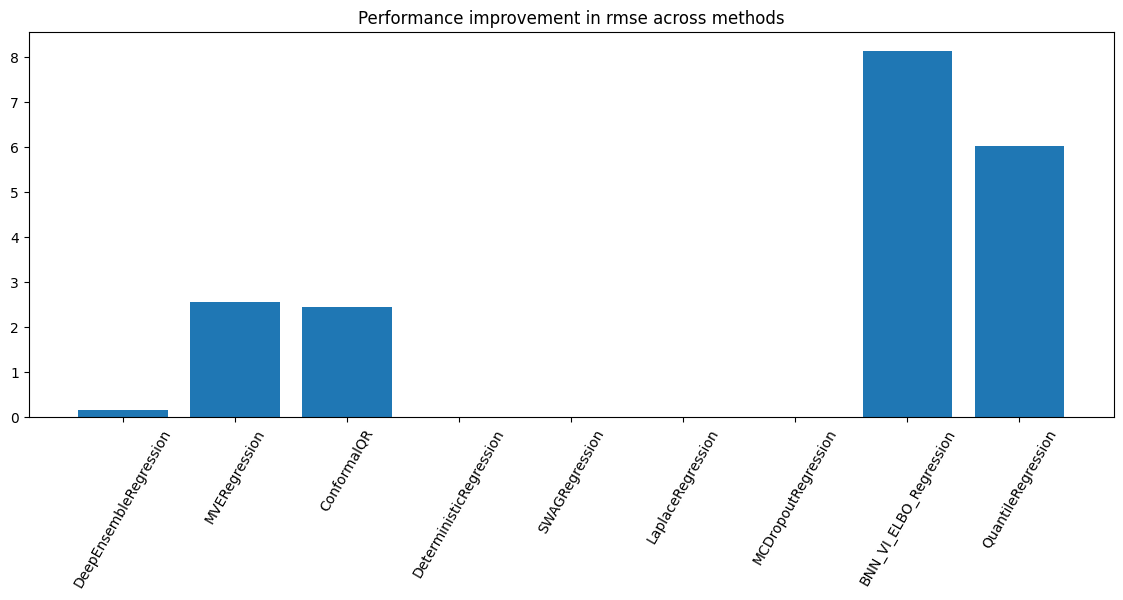

In [12]:
metric = "rmse"
diff_train = diff_df[diff_df["split"] == "preds_train"].reset_index(drop=True)
diff_test = diff_df[diff_df["split"] == "preds_val"].reset_index(drop=True)
fig, ax = plt.subplots(1)
ax.bar(diff_test["uqmethod"].values, diff_test[metric].values)
plt.title(f"Performance improvement in {metric} across methods")
plt.xticks(rotation=60)

In [13]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,TD,TS,H1,H2,H3,H4,H5,count_total,uqmethod
0,3.949773,6.848777,3.457718,35.533872,0.064776,0.056251,0.056815,13.124806,9.342684,12.698880,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,DKLRegression
1,3.948189,6.840202,3.453518,35.380966,0.065011,0.055761,0.056318,13.164921,9.340257,12.586209,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,DKLRegression
2,3.861324,6.293967,3.177965,32.147210,0.082573,0.072472,0.073201,13.120582,8.623980,11.356123,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,DKLRegression
3,8.136559,6.426349,3.237124,43.693295,0.293272,0.259322,0.261941,4.355804,7.965660,10.734714,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,DeepEnsembleRegression
4,17.189863,11.918841,5.994319,92.382868,0.410286,0.359223,0.362851,4.799973,13.921910,17.676627,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,DeepEnsembleRegression
5,6.982936,5.320473,2.681130,34.810293,0.275524,0.244254,0.246721,4.030653,6.703995,8.676841,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,DeepEnsembleRegression
6,3.680710,5.611008,2.832834,28.328867,0.048056,0.043531,0.043971,8.686996,7.853035,10.584424,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,MVERegression
7,3.734119,5.509172,2.781326,27.991011,0.066159,0.059740,0.060344,8.340462,7.686972,10.323922,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,MVERegression
8,3.384565,4.330035,2.186459,21.112597,0.023574,0.020654,0.020863,8.599856,6.149197,8.106473,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,MVERegression
9,4.337493,8.017922,4.047227,42.724177,0.147037,0.132105,0.133440,9.363187,10.937527,14.185573,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,ConformalQR


The number of samples being removed per category as a percentage.

In [14]:
sample_remain_pct = (
    uq_metric_df[CLASS_LABELS + ["count_total"]]
    - selective_df[CLASS_LABELS + ["count_total"]]
) / uq_metric_df[CLASS_LABELS + ["count_total"]]
sample_remain_pct.insert(0, ("split"), uq_metric_df["split"])
sample_remain_pct.insert(0, ("UQ Method"), uq_metric_df["uqmethod"])
print(sample_remain_pct)

                  UQ Method        split        TD        TS        H1  \
0             DKLRegression    preds_val  1.000000  1.000000  1.000000   
1             DKLRegression   preds_test  1.000000  1.000000  1.000000   
2             DKLRegression  preds_train  1.000000  1.000000  1.000000   
3    DeepEnsembleRegression    preds_val  0.001285  0.008530  0.034965   
4    DeepEnsembleRegression   preds_test  0.009891  0.033208  0.068772   
5    DeepEnsembleRegression  preds_train  0.000572  0.005100  0.021786   
6             MVERegression    preds_val  0.057519  0.439414  0.763986   
7             MVERegression   preds_test  0.050132  0.435945  0.820351   
8             MVERegression  preds_train  0.049199  0.431775  0.812732   
9               ConformalQR    preds_val  0.101864  0.458224  0.837413   
10              ConformalQR   preds_test  0.075751  0.490478  0.880234   
11              ConformalQR  preds_train  0.095767  0.482777  0.889679   
12  DeterministicRegression    preds_v

                  UQ Method storm_category     value
0             DKLRegression             TD  1.000000
1    DeepEnsembleRegression             TD  0.009891
2             MVERegression             TD  0.050132
3               ConformalQR             TD  0.075751
4   DeterministicRegression             TD  0.000000
..                      ...            ...       ...
75           SWAGRegression    count_total  0.000000
76        LaplaceRegression    count_total  1.000000
77      MCDropoutRegression    count_total  0.999862
78   BNN_VI_ELBO_Regression    count_total  0.684038
79       QuantileRegression    count_total       NaN

[80 rows x 3 columns]
                  UQ Method storm_category     value
0             DKLRegression             TD  1.000000
1    DeepEnsembleRegression             TD  0.009891
2             MVERegression             TD  0.050132
3               ConformalQR             TD  0.075751
4   DeterministicRegression             TD  0.000000
5            SWAGRegres

/tmp/ipykernel_22577/3961672970.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


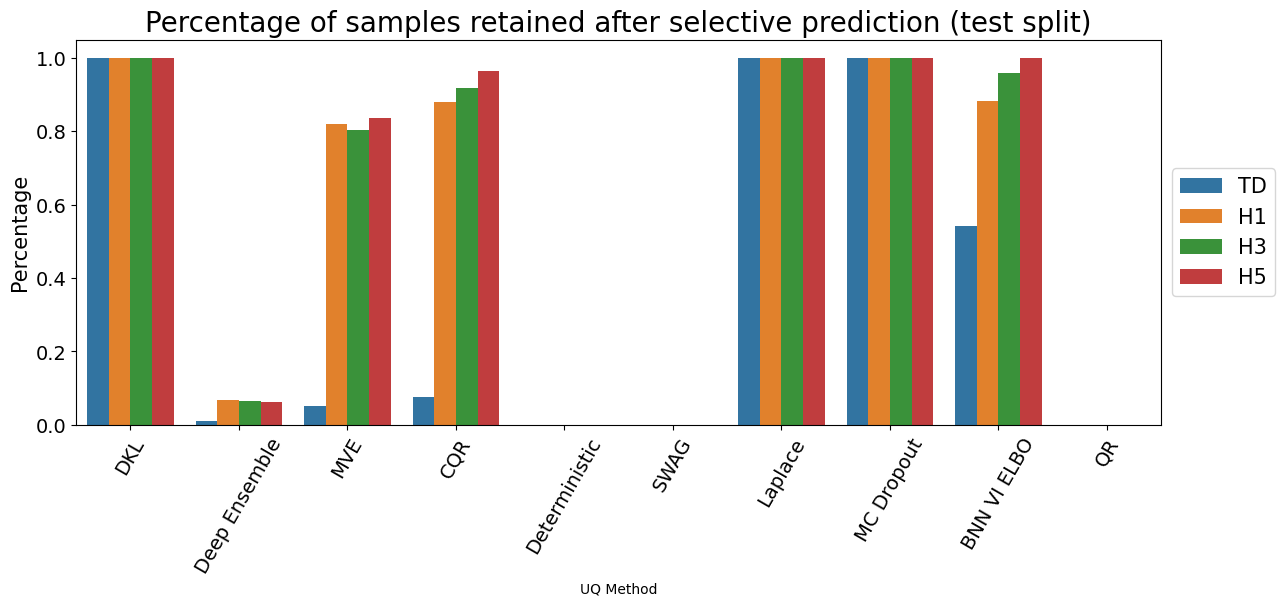

In [15]:
def plot_sample_percentage(sample_remain_pct, split_type):
    # Filter the DataFrame based on the split type
    count = sample_remain_pct[
        sample_remain_pct["split"] == f"preds_{split_type}"
    ].reset_index(drop=True)

    # Melt the DataFrame to long format
    count = pd.melt(
        count,
        id_vars="UQ Method",
        value_vars=CLASS_LABELS + ["count_total"],
        var_name="storm_category",
    )
    print(count)
    count = count[count["storm_category"].isin(STORM_DISPLAY_ORDER)]

    print(count)
    # Create the bar plot
    fig, ax = plt.subplots(1)
    sns.barplot(x="UQ Method", y="value", hue="storm_category", data=count, ax=ax)
    plt.ylabel("Percentage", fontsize=15)
    plt.title(
        f"Percentage of samples retained after selective prediction ({split_type} split)",
        fontsize=20,
    )
    plt.xticks(rotation=60, fontsize=14)
    plt.yticks(fontsize=14)

    # Set the x-tick labels using the VAR_TO_PLOT_LABEL dictionary
    ax.set_xticklabels(
        [VAR_TO_PLOT_LABEL[label.get_text()] for label in ax.get_xticklabels()]
    )

    # Increase the size of the legend and place it next to the plot
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), prop={"size": 15})

    plt.show()


# Call the function with 'train' or 'val' as the argument
plot_sample_percentage(sample_remain_pct, DS_SPLIT)

# All preds in a single DF

In [16]:
overview_df["split"] = overview_df["pred_path"].str.split(os.sep, expand=True)[7]

all_test_pred_df = []
for idx, row in overview_df.iterrows():
    pred_df = pd.read_csv(row["pred_path"])
    pred_df["uqmethod"] = row["uqmethod"]
    if row["split"] == "preds.csv":
        pred_df["split"] = "preds_test"
    else:
        pred_df["split"] = row["split"].split(".")[0]

    pred_df["pred_path"] = row["pred_path"]
    all_test_pred_df.append(pred_df)

from scipy import stats

# test_df = overview_df[overview_df["split"]=="preds"]

all_test_pred_df = pd.concat(all_test_pred_df, ignore_index=True)


def get_normalization_params(group):
    pred_path = group["pred_path"].iloc[0]
    TARGET_MEAN, TARGET_STD = (
        NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_mean"],
        NORMALIZATION_PARAMS[os.path.dirname(pred_path)]["target_std"],
    )
    group["target_mean"] = TARGET_MEAN
    group["target_std"] = TARGET_STD
    return group


all_test_pred_df = all_test_pred_df.groupby("pred_path").apply(get_normalization_params)

# normalize
all_test_pred_df["pred"] = (
    all_test_pred_df["pred"] * all_test_pred_df["target_std"]
) + all_test_pred_df["target_mean"]
all_test_pred_df["target"] = (
    all_test_pred_df["target"] * all_test_pred_df["target_std"]
) + all_test_pred_df["target_mean"]
all_test_pred_df["pred_uct"] = (
    all_test_pred_df["pred_uct"] * all_test_pred_df["target_std"]
)

all_test_pred_df["storm_category"] = pd.cut(
    all_test_pred_df["target"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
)
all_test_pred_df["mse"] = (all_test_pred_df["pred"] - all_test_pred_df["target"]) ** 2
all_test_pred_df["mae"] = np.abs(all_test_pred_df["pred"] - all_test_pred_df["target"])
all_test_pred_df["nll"] = -1 * stats.norm.logpdf(
    all_test_pred_df["pred"] - all_test_pred_df["target"],
    scale=all_test_pred_df["pred_uct"],
)

# date
pattern = r"(\d{2}-\d{2}-\d{4}_\d{2}-\d{2}-\d{6})"

# Extract dates and create a new column
all_test_pred_df["date"] = all_test_pred_df["pred_path"].str.extract(pattern)

# Convert the new_date_column to datetime format
all_test_pred_df["date"] = pd.to_datetime(
    all_test_pred_df["date"], format="%m-%d-%Y_%H-%M"
)

all_test_pred_df = all_test_pred_df.reset_index(drop=True)
all_test_pred_df = all_test_pred_df.dropna(subset=["mse", "mae"], how="any")
all_test_pred_df

,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,storm_id,relative_time,ocean,...,aleatoric_uct,lower_quant,upper_quant,target_mean,target_std,storm_category,mse,mae,nll,date
0,23.605001,7.041687,0.262796,33.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,307798.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TS,88.266012,9.394999,3.760827,NaT
1,23.552160,7.035458,0.262563,33.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,309598.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TS,89.261688,9.447840,3.771577,NaT
2,23.492728,6.982305,0.260580,32.000001,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,313198.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TD,72.373687,8.507273,3.604573,NaT
3,23.474389,6.974964,0.260306,32.000001,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,314998.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TD,72.686047,8.525611,3.608294,NaT
4,23.489451,6.985480,0.260698,31.000000,BNN_VI_ELBO_Regression,preds_test,/p/project/hai_uqmethodbox/experiment_output/m...,acd,316799.0,1.0,...,NaN,NaN,NaN,50.344009,26.795277,TD,56.408344,7.510549,3.440763,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1153220,56.386234,1.289038,0.048107,71.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,NaN,50.344009,26.795277,H1,213.562166,14.613766,65.436110,NaT
1153221,100.028698,3.766379,0.140561,110.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,NaN,50.344009,26.795277,H3,99.426867,9.971302,5.749550,NaT
1153222,37.059294,2.052050,0.076583,43.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,NaN,50.344009,26.795277,TS,35.291979,5.940705,5.828320,NaT
1153223,42.997452,0.912734,0.034063,34.000000,SWAGRegression,preds_val,/p/project/hai_uqmethodbox/experiment_output/m...,NaN,NaN,NaN,...,NaN,NaN,NaN,50.344009,26.795277,TS,80.954142,8.997452,49.414722,NaT


In [17]:
cqr = all_test_pred_df[all_test_pred_df["uqmethod"] == "ConformalQR"]
print(cqr.shape)
cqr[cqr["pred_uct"] < 0]

(110319, 21)


,pred,pred_uct,epistemic_uct,target,uqmethod,split,pred_path,storm_id,relative_time,ocean,...,aleatoric_uct,lower_quant,upper_quant,target_mean,target_std,storm_category,mse,mae,nll,date


In [18]:
all_test_pred_df[all_test_pred_df["pred_uct"].isna()]["uqmethod"].unique()

array(['DeterministicRegression'], dtype=object)

In [19]:
laplace_df = all_test_pred_df[all_test_pred_df["uqmethod"] == "LaplaceRegression"]
abs(laplace_df["target_mean"] - laplace_df["target"]).std() / 26.795276641845703

0.5938519918125249

## Dataframe with Metrics per Category

In [20]:
group_cols = ["uqmethod", "pred_path", "storm_category"]
category_df = all_test_pred_df.groupby(by=group_cols, observed=False)[
    ["mse", "mae", "nll", "pred_uct"]
].mean()
category_df.reset_index(inplace=True)
category_df.rename(columns={"pred_uct": "sharpness"}, inplace=True)
category_df["rmse"] = category_df["mse"] ** 0.5
category_df["split"] = (
    category_df["pred_path"].str.rsplit("/", n=1).str[-1].str.rsplit(".").str[0]
)
category_df["split"] = category_df["split"].replace("preds", "preds_test")
category_df["contains"] = [
    x[0] in x[1] for x in zip(category_df["uqmethod"], category_df["pred_path"])
]
category_df = category_df[category_df["contains"] == True]

category_df = category_df[
    ~((category_df["uqmethod"] == "MCDropoutRegression") & category_df["rmse"].isna())
]
category_df = category_df[
    ~((category_df["uqmethod"] == "DKLRegression") & category_df["rmse"].isna())
]
# category_df = category_df[~((category_df['uqmethod'] == 'BaseModel') & category_df['rmse'].isna())]

del category_df["contains"]
# compute other metrics of interest
quantile = 0.95
result = (
    all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
    .groupby(group_cols, observed=False)
    .apply(
        lambda x: uct.get_proportion_in_interval(
            x["pred"].values,
            x["pred_uct"].values,
            x["target"].values,
            quantile=quantile,
        )
    )
    .reset_index()
)
result.rename(columns={0: f"proportion_in_{quantile}_interval"}, inplace=True)

category_df = pd.merge(
    category_df, result, how="left", left_on=group_cols, right_on=group_cols
)

columns_to_check = ["mse", "mae", "nll", "sharpness", "rmse"]
category_df = category_df.dropna(subset=columns_to_check)
category_df

,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
0,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TD,50.592608,5.335652,3.412173,9.148264,7.112848,preds_test,0.981078
1,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,TS,100.149555,8.060430,3.757488,9.893171,10.007475,preds_test,0.934698
2,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,462.593001,19.523507,5.516000,11.495183,21.507975,preds_test,0.579181
3,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,950.247750,29.071949,7.217251,12.808685,30.826089,preds_test,0.347328
4,BNN_VI_ELBO_Regression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,1490.841338,36.000320,8.891433,14.456265,38.611415,preds_test,0.351970
...,...,...,...,...,...,...,...,...,...,...
219,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H1,200.613041,11.590368,58.862262,1.996157,14.163793,preds_val,0.227273
220,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H2,216.225972,11.665915,32.132842,2.477955,14.704624,preds_val,0.240185
221,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H3,224.650628,11.833400,29.611459,2.544096,14.988350,preds_val,0.256803
222,SWAGRegression,/p/project/hai_uqmethodbox/experiment_output/m...,H4,465.754388,17.936542,71.906464,2.694095,21.581344,preds_val,0.150358


In [21]:
with pd.option_context("display.max_colwidth", None):
    display(category_df[category_df["uqmethod"] == "DKLRegression"])

,uqmethod,pred_path,storm_category,mse,mae,nll,sharpness,rmse,split,proportion_in_0.95_interval
56,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,TD,92.291948,7.327655,3.755604,12.955040,9.606870,preds_test,0.984579
57,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,TS,132.055877,8.423561,3.887062,13.125434,11.491557,preds_test,0.961647
58,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H1,293.895942,14.476544,4.358168,13.718709,17.143394,preds_test,0.879064
59,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H2,399.742069,16.765970,4.542413,13.574875,19.993551,preds_test,0.821883
60,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H3,484.243288,17.986463,4.776416,13.219712,22.005529,preds_test,0.756671
61,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H4,233.682156,11.038174,4.172190,13.005219,15.286666,preds_test,0.909478
62,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_test.csv,H5,369.309979,17.540630,4.535181,13.387369,19.217439,preds_test,0.891156
63,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,TD,77.976933,7.019707,3.710547,12.941712,8.830455,preds_train,0.992162
64,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,TS,108.103654,7.662263,3.811378,13.050349,10.397291,preds_train,0.968630
65,DKLRegression,/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_DKLRegression_01-31-2024_20-12-11-835876/preds_train.csv,H1,213.549206,12.323096,4.117912,13.557479,14.613323,preds_train,0.942367


In [22]:
# Make latex table
def generate_latex_table(category_df, split_type):
    metric_columns = ["rmse", "nll"]

    table_labels = category_df["storm_category"].unique()
    columns = pd.MultiIndex.from_product([table_labels, metric_columns])
    combined_df = pd.DataFrame(columns=columns)

    latex_df = category_df[category_df["split"] == f"preds_{split_type}"]

    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    latex_df["uqmethod"] = latex_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    for split in table_labels:
        split_df = latex_df[latex_df["storm_category"] == split]
        for metric in metric_columns:
            combined_df[(split, metric)] = split_df[metric].values

    combined_df.insert(0, ("", "uqmethod"), latex_df["uqmethod"].unique())
    combined_df = combined_df.round(3)

    latex_table = as_latex_output(combined_df)
    return latex_table


def as_latex_output(combined_df):
    combined_df = combined_df.round(3)
    # print(combined_df.max())
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.3f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )
        # latex_column = column.replace("_", "\\_")
        # latex_output = latex_output.replace(column, latex_column)

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("rmse", "rmse $\downarrow$")
    latex_output = latex_output.replace("nll", "nll $\downarrow$")
    # latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrr}", "l|cc|cc|cc|cc|cc")
    latex_output = latex_output.replace("\multicolumn{2}{r}", "\multicolumn{2}{c}")
    latex_output = latex_output.replace("\textbf{BNN\_VI\_ELBO}", "BNN\_VI\_ELBO")
    return latex_output


latex_table = generate_latex_table(category_df, DS_SPLIT)
print(latex_table)

/tmp/ipykernel_22577/684979901.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latex_df["uqmethod"] = latex_df["uqmethod"].apply(


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & \multicolumn{2}{c}{TD} & \multicolumn{2}{c}{TS} & \multicolumn{2}{c}{H1} & \multicolumn{2}{c}{H2} & \multicolumn{2}{c}{H3} & \multicolumn{2}{c}{H4} & \multicolumn{2}{c}{H5} \\
uqmethod & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ & rmse $\downarrow$ & nll $\downarrow$ \\
\midrule
\textbf{BNN VI ELBO} & 7.113 & 3.412 & 10.007 & \textbf{3.757} & 21.508 & 5.516 & 30.826 & 7.217 & 38.611 & 8.891 & 46.167 & 9.243 & 61.754 & 11.557 \\
CQR & \textbf{5.442} & 3.188 & 13.203 & 4.682 & 21.572 & 5.738 & 22.479 & 5.382 & 23.730 & 5.572 & 22.183 & 5.125 & 27.421 & 5.799 \\
DKL & 9.607 & 3.756 & 11.492 & 3.887 & 17.143 & 4.358 & 19.994 & 4.542 & 22.006 & 4.776 & \textbf{15.287} & \textbf{4.172} & 19.217 & \textbf{4.535} \\
Deep Ensemble & 16.620 & 19.336 & 12.129 & 9.40

['TD', 'H1', 'H3', 'H5']
Categories (4, object): ['TD' < 'H1' < 'H3' < 'H5']


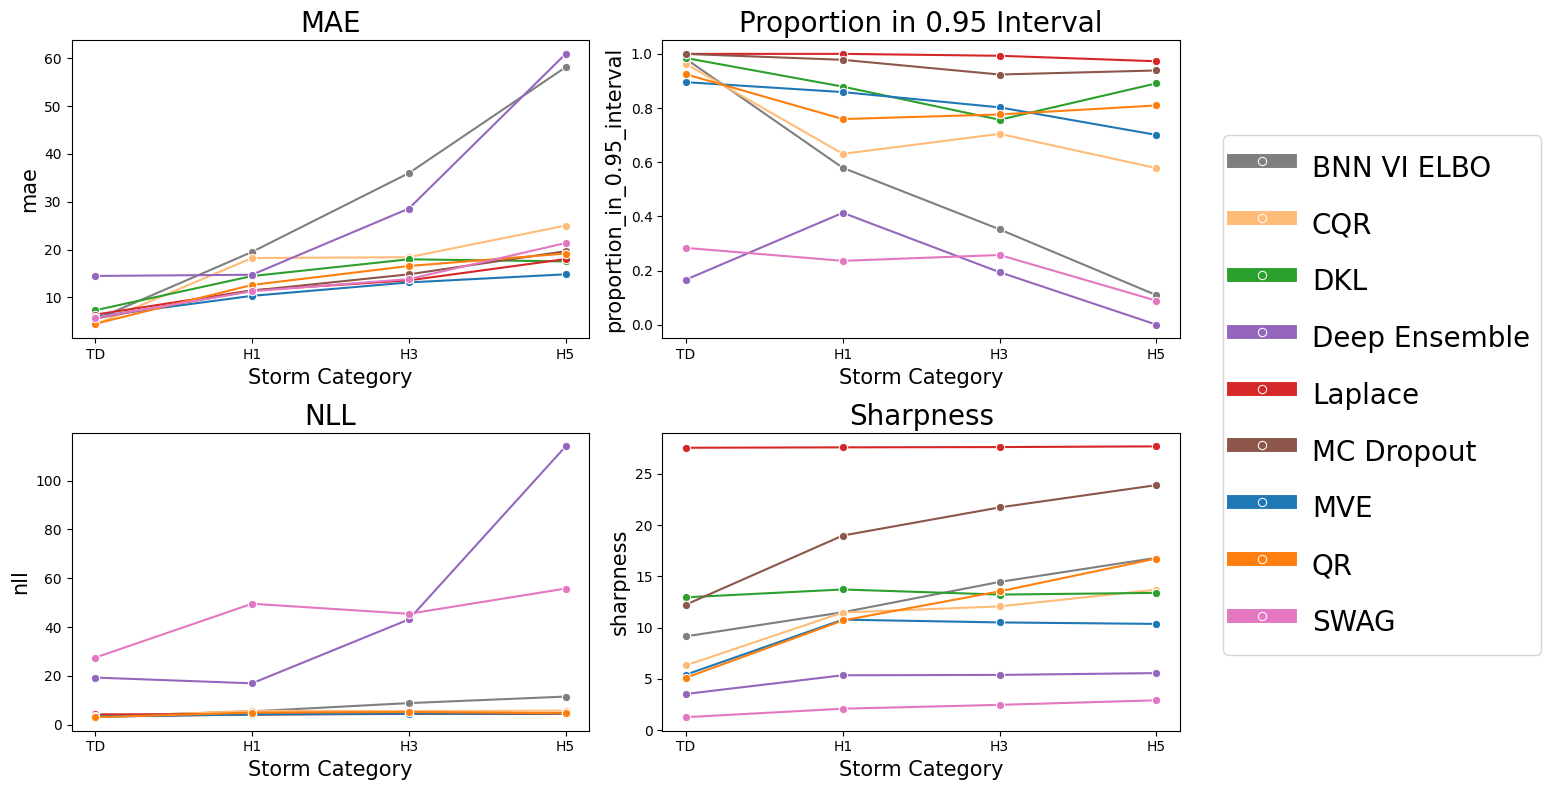

In [23]:
def plot_metrics_by_category(category_df, split_type):
    plot_cat_df = category_df[category_df["split"] == f"preds_{split_type}"]

    # plot per category
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Assuming 'category' is the column used for x-axis and 'metrics' are the columns to be plotted
    metrics = ["mae", "proportion_in_0.95_interval", "nll", "sharpness"]

    plot_cat_df = plot_cat_df[plot_cat_df["uqmethod"] != "DERModel"]

    plot_cat_df = plot_cat_df[plot_cat_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_cat_df["storm_category"] = plot_cat_df[
        "storm_category"
    ].cat.remove_unused_categories()
    print(plot_cat_df["storm_category"].unique())

    # Loop through the subplots
    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2

        # Create the sns plot
        sns.lineplot(
            x="storm_category",
            y=metric,
            hue="uqmethod",
            data=plot_cat_df,
            ax=axes[row, col],
            marker="o",
            palette=color_palette,
        )

        # Add title and increase the size
        axes[row, col].set_title(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)

        # Increase the size of the x and y labels
        axes[row, col].set_xlabel("Storm Category", fontsize=15)
        axes[row, col].set_ylabel(metric, fontsize=15)

        # Increase the size of the x and y ticks
        axes[row, col].tick_params(axis="both", which="major", labelsize=10)

    # set the linewidths to the copies
    handles, labels = axes[0, 0].get_legend_handles_labels()
    [ha.set_linewidth(10) for ha in handles]

    # Replace the labels using the VAR_TO_PLOT_LABEL dictionary
    labels = [
        VAR_TO_PLOT_LABEL[label] if label in VAR_TO_PLOT_LABEL else label
        for label in labels
    ]

    # Increase the size of the legend labels
    fig.legend(
        handles,
        labels,
        loc="center right",
        bbox_to_anchor=(1.3, 0.5),
        fontsize=20,
        handleheight=2,
    )

    # Remove individual legends
    for ax in axes.flat:
        ax.get_legend().remove()

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()


# Call the function with 'train' or 'val' as the argument
plot_metrics_by_category(category_df, DS_SPLIT)

# Tables

## RMSE Overview Table

In [24]:
def generate_latex_table(uq_metric_df, selective_df, split_type):
    category_columns = ["rmse", "crps", "nll"]
    # table_columns = ["default", "diff"]
    # columns = pd.MultiIndex.from_product(
    #     [["default", "diff"]]
    # )
    combined_df = pd.DataFrame(columns=category_columns)

    table_uq_df = uq_metric_df[uq_metric_df["split"] == f"preds_{split_type}"]
    table_selective_df = selective_df[selective_df["split"] == f"preds_{split_type}"]


    # Replace the uqmethod values using the VAR_TO_PLOT_LABEL dictionary
    table_uq_df["uqmethod"] = table_uq_df["uqmethod"].apply(
        lambda x: VAR_TO_PLOT_LABEL[x] if x in VAR_TO_PLOT_LABEL else x
    )

    for metric in category_columns:
        # combined_df[(split_type, metric, "selective")] = table_selective_df[metric]
        combined_df[(metric)] = table_uq_df[metric]
        if "rmse" == metric:
            diff_rmse = table_uq_df[metric] - table_selective_df[metric]
            combined_df.insert(combined_df.columns.get_loc(metric) + 1, "diff rmse", diff_rmse)
            coverage = table_selective_df["count_total"] / table_uq_df["count_total"]
            combined_df.insert(combined_df.columns.get_loc("diff rmse") + 1, "coverage", coverage)
            

    combined_df.insert(0, ("uqmethod"), table_uq_df["uqmethod"])
    combined_df = combined_df.round(4)

    latex_table = as_latex_output(combined_df, category_columns)
    return latex_table


def as_latex_output(combined_df, category_columns):
    combined_df = combined_df.round(4)
    max_values = combined_df.max()
    min_values = combined_df.min()
    latex_output = combined_df.to_latex(escape=False, index=False, float_format="%.4f")

    for column in max_values.index:
        if "diff" in column:
            latex_output = latex_output.replace(
                str(max_values[column]), "\\textbf{" + str(max_values[column]) + "}"
            )
        else:
            latex_output = latex_output.replace(
                str(min_values[column]), "\\textbf{" + str(min_values[column]) + "}"
            )

    # Replace the category_columns values using the VAR_TO_PLOT_LABEL dictionary
    for column in category_columns:
        latex_output = latex_output.replace(
            column, VAR_TO_PLOT_LABEL[column] if column in VAR_TO_PLOT_LABEL else column
        )

    latex_output = latex_output.replace("_", "\\_")
    latex_output = latex_output.replace("\multicolumn{3}{r}", "\multicolumn{3}{c}")
    latex_output = latex_output.replace("diff", "$\Delta$ $\downarrow$")
    latex_output = latex_output.replace("down", "up")
    latex_output = latex_output.replace("default", "default $\downarrow$")
    latex_output = latex_output.replace("selective", "selective $\downarrow$")
    latex_output = latex_output.replace("Model", "")
    latex_output = latex_output.replace("{lrrrrrrrrrrrr}", "{lccc|ccc|ccc|ccc}")
    latex_output = latex_output.replace(
        "\multicolumn{6}{r}{Train}", "\multicolumn{6}{c}{Train}"
    )
    latex_output = latex_output.replace(
        "\multicolumn{6}{r}{Test}", "\multicolumn{6}{c}{Test}"
    )
    return latex_output


latex_table = generate_latex_table(uq_metric_df, selective_df, DS_SPLIT)
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
uqmethod & RMSE & $\Delta$ $\uparrow$ RMSE & coverage & CRPS & NLL \\
\midrule
DKL & 12.5862 & NaN & \textbf{0.0}000 & 6.8402 & 3.9482 \\
Deep Ensemble & 17.6766 & 0.1392 & 0.9680 & 11.9188 & 17.1899 \\
MVE & 10.3239 & 2.1779 & 0.6362 & \textbf{5.5092} & \textbf{3.7341} \\
CQR & 13.5495 & 2.5348 & 0.5841 & 7.4169 & 4.2986 \\
Deterministic & 10.4962 & \textbf{0.0}000 & 1.0000 & NaN & NaN \\
SWAG & 10.2585 & \textbf{0.0}000 & 1.0000 & 6.8377 & 31.4989 \\
Laplace & 10.5276 & NaN & \textbf{0.0}000 & 7.9627 & 4.3081 \\
MC Dropout & \textbf{10.2297} & \textbf{6.1238} & \textbf{0.0}001 & 5.7792 & 3.8104 \\
\textbf{BNN VI ELBO} & 15.9432 & 5.5349 & 0.3160 & 8.1473 & 4.2551 \\
QR & 10.7796 & NaN & NaN & 5.6726 & 3.8925 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_22577/651817927.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_uq_df["uqmethod"] = table_uq_df["uqmethod"].apply(


In [25]:
uq_metric_df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,pred_path,TD,TS,H1,H2,H3,H4,H5,count_total,uqmethod
0,3.949773,6.848777,3.457718,35.533872,0.064776,0.056251,0.056815,13.124806,9.342684,12.698880,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,DKLRegression
1,3.948189,6.840202,3.453518,35.380966,0.065011,0.055761,0.056318,13.164921,9.340257,12.586209,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,DKLRegression
2,3.861324,6.293967,3.177965,32.147210,0.082573,0.072472,0.073201,13.120582,8.623980,11.356123,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,DKLRegression
3,8.136559,6.426349,3.237124,43.693295,0.293272,0.259322,0.261941,4.355804,7.965660,10.734714,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,DeepEnsembleRegression
4,17.189863,11.918841,5.994319,92.382868,0.410286,0.359223,0.362851,4.799973,13.921910,17.676627,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,DeepEnsembleRegression
5,6.982936,5.320473,2.681130,34.810293,0.275524,0.244254,0.246721,4.030653,6.703995,8.676841,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,DeepEnsembleRegression
6,3.680710,5.611008,2.832834,28.328867,0.048056,0.043531,0.043971,8.686996,7.853035,10.584424,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,MVERegression
7,3.734119,5.509172,2.781326,27.991011,0.066159,0.059740,0.060344,8.340462,7.686972,10.323922,...,/p/project/hai_uqmethodbox/experiment_output/m...,16277,18851,4275,1572,1574,939,147,43635,MVERegression
8,3.384565,4.330035,2.186459,21.112597,0.023574,0.020654,0.020863,8.599856,6.149197,8.106473,...,/p/project/hai_uqmethodbox/experiment_output/m...,17480,24705,6472,2662,2660,2041,328,56348,MVERegression
9,4.337493,8.017922,4.047227,42.724177,0.147037,0.132105,0.133440,9.363187,10.937527,14.185573,...,/p/project/hai_uqmethodbox/experiment_output/m...,3112,4572,1144,433,588,419,68,10336,ConformalQR


## Metric Computation per Category

In [26]:
category_columns = ["rmse", "nll", "sharpness"]
splits = [""]

columns = pd.MultiIndex.from_product(
    [splits, category_columns, ["default", "selective", "diff"]]
)
combined_df = pd.DataFrame(columns=columns)

## Error Analysis per Category

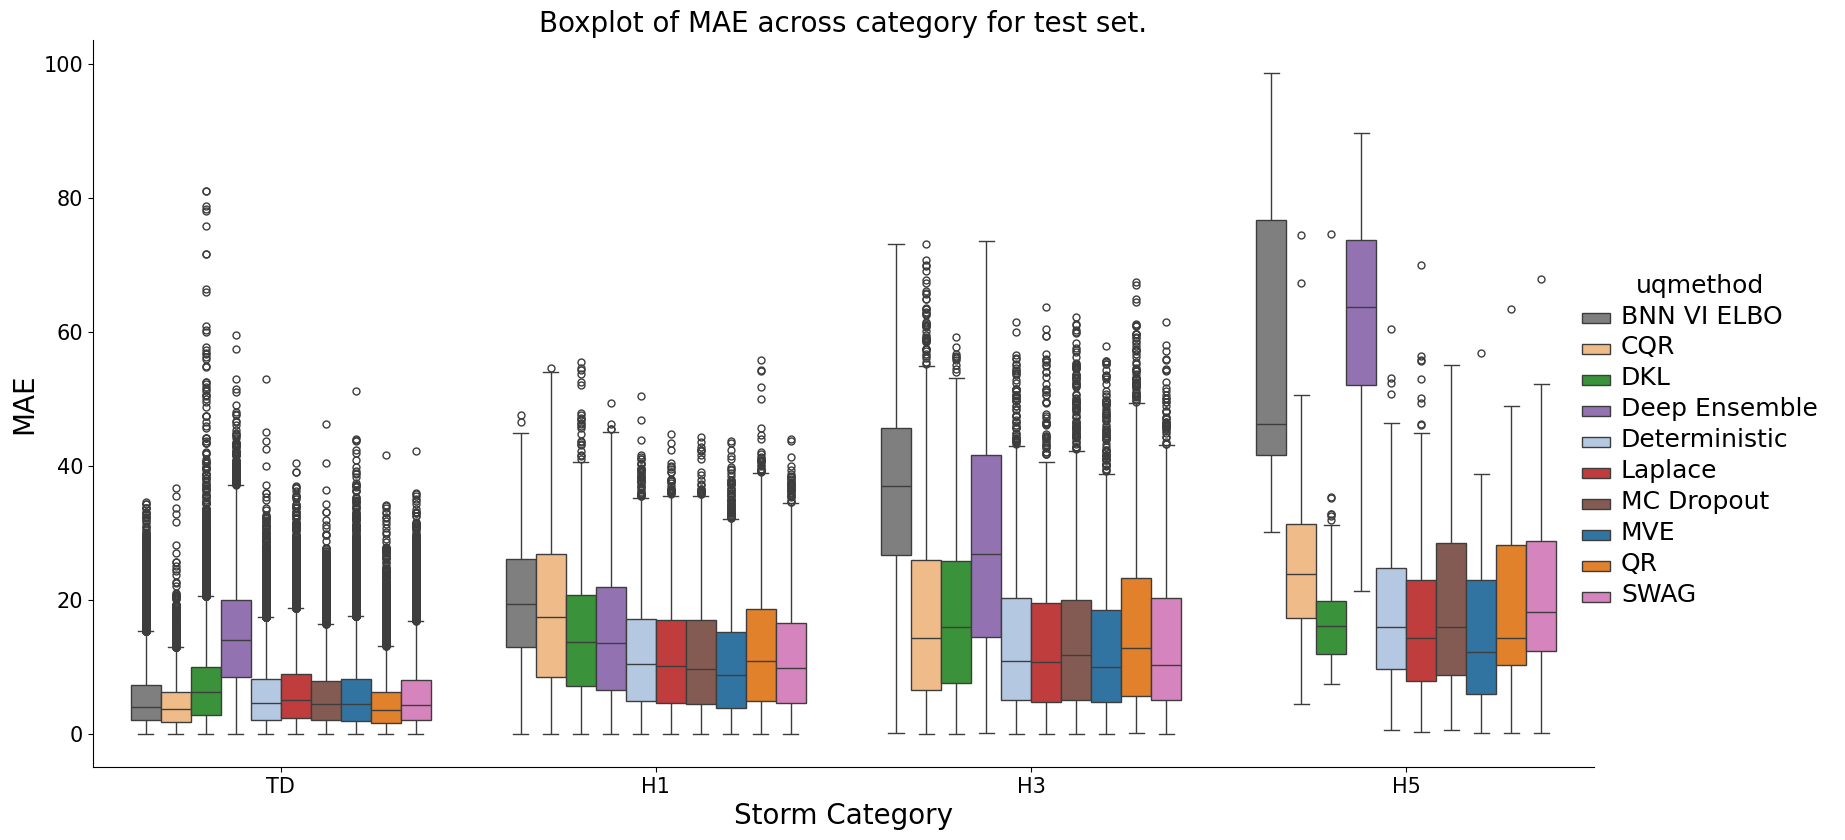

In [27]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(
        lambda x: x.isna().any()
    )
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()

    g = sns.catplot(
        plot_df,
        kind="box",
        x="storm_category",
        y=metric,
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
    )

    ax = g.ax

    # Add horizontal lines behind each x value group
    for i, artist in enumerate(ax.artists):
        if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
            artist.set_edgecolor("black")  # Set the edge color to black

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    plt.title(
        f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.",
        fontsize=20,
    )
    plt.ylabel(f"{VAR_TO_PLOT_LABEL[metric]}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with 'val' or 'train' as the split argument and 'mae' or any other metric as the metric argument
plot_boxplot(all_test_pred_df, DS_SPLIT, "mae")

# Selective prediction per Storm Category

In [28]:
from sklearn.metrics import mean_squared_error


def generate_summary_table(all_test_pred_df, split):
    # Compute RMSE for all samples per uqmethod
    rmse_all_samples = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby("uqmethod", observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all_samples.columns = ["uqmethod", "RMSE_All"]

    # Add the "all" category
    rmse_all_samples["storm_category"] = "all"

    # Compute RMSE per method and category
    rmse_all = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all.columns = ["uqmethod", "storm_category", "RMSE_All"]

    # Append the new rows to the RMSE_All DataFrame
    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(["pred_path", "storm_category"], observed=False)
        .apply(
            lambda group: group[
                group["pred_uct"]
                < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]
            ]
        )
        .reset_index(drop=True)
    )

    rmse_all_samples_filtered = (
        df_filtered.groupby("uqmethod", observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_all_samples_filtered.columns = ["uqmethod", "RMSE_Uncertainty_Less_Threshold"]

    # Add the "all" category
    rmse_all_samples_filtered["storm_category"] = "all"

    # Compute RMSE per method and category for the filtered DataFrame
    rmse_filtered = (
        df_filtered.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.sqrt(mean_squared_error(x["pred"], x["target"])))
        .reset_index()
    )
    rmse_filtered.columns = [
        "uqmethod",
        "storm_category",
        "RMSE_Uncertainty_Less_Threshold",
    ]

    # Append the new rows to the RMSE_Uncertainty_Less_Threshold DataFrame
    rmse_filtered = pd.concat(
        [rmse_filtered, rmse_all_samples_filtered], ignore_index=True
    )

    # Merge the two DataFrames on method and category
    summary_table = pd.merge(
        rmse_all, rmse_filtered, on=["uqmethod", "storm_category"], how="left"
    )

    # If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
    summary_table.fillna({"RMSE_Uncertainty_Less_Threshold": np.nan}, inplace=True)

    summary_table["pct_change"] = (
        (summary_table["RMSE_Uncertainty_Less_Threshold"] - summary_table["RMSE_All"])
        / summary_table["RMSE_All"]
    ) * 100
    summary_table["abs_change"] = np.abs(
        summary_table["RMSE_Uncertainty_Less_Threshold"] - summary_table["RMSE_All"]
    )
    summary_table["abs_change"] = summary_table["abs_change"].fillna(0)

    return summary_table


# Call the function with 'val' or 'train' as the argument
summary_table = generate_summary_table(all_test_pred_df, DS_SPLIT)
print(summary_table)

KeyError: '/p/project/hai_uqmethodbox/experiment_output/min_wind_speed_0_new/cyclone_CARDRegression_01-31-2024_11-12-56-727921'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_bar(summary_table):
    # Convert the storm_category column to 'category' dtype
    summary_table["storm_category"] = summary_table["storm_category"].astype("category")

    # Now you can use the cat accessor
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()

    hue_order = summary_table["uqmethod"].unique().tolist()

    # remove categories with no predictions
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()

    summary_table = summary_table[
        summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)
    ]

    # Use the order parameter in the catplot function
    g = sns.catplot(
        data=summary_table,
        kind="bar",
        x="storm_category",
        y="RMSE_All",
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax = g.ax

    sns.barplot(
        data=summary_table,
        x="storm_category",
        y="RMSE_Uncertainty_Less_Threshold",
        hue="uqmethod",
        alpha=0.0,
        ax=ax,
        hatch="...",
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax.get_legend().remove()

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )
    plt.title(
        "RMSE scores per category. Dotted bars show RMSE after applying selective prediction.",
        fontsize=20,
    )
    plt.ylabel("RMSE", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)

    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with the summary table as the argument
plot_bar(summary_table)

NameError: name 'summary_table' is not defined

In [ ]:
def compute_summary(all_test_pred_df, split):
    rmse_all_samples = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby("uqmethod", observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_all_samples.columns = ["uqmethod", "SHARP_All"]

    # Add the "all" category
    rmse_all_samples["storm_category"] = "all"

    # Compute RMSE per method and category
    rmse_all = (
        all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
        .groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_all.columns = ["uqmethod", "storm_category", "SHARP_All"]

    # Append the new rows to the RMSE_All DataFrame
    rmse_all = pd.concat([rmse_all, rmse_all_samples], ignore_index=True)

    # Filter data where uncertainty is less than the threshold
    df_filtered = (
        all_test_pred_df[all_test_pred_df["uqmethod"] != "DeterministicRegression"]
        .groupby(["pred_path", "storm_category"], observed=False)
        .apply(
            lambda group: group[
                group["pred_uct"]
                < SELECTIVE_PRED_DICT[os.path.dirname(group.name[0])][group.name[1]]
            ]
        )
        .reset_index(drop=True)
    )

    # Compute RMSE per method and category over filtered predictions
    rmse_filtered = (
        df_filtered.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda x: np.mean(x["pred_uct"]))
        .reset_index()
    )
    rmse_filtered.columns = [
        "uqmethod",
        "storm_category",
        "SHARP_Uncertainty_Less_Threshold",
    ]

    # Merge the two DataFrames on method and category
    summary_table = pd.merge(
        rmse_all, rmse_filtered, on=["uqmethod", "storm_category"], how="left"
    )

    # If there are some categories/methods where no data meets the threshold condition, you might want to replace NaNs with a specific value
    summary_table.fillna({"SHARP_Uncertainty_Less_Threshold": np.nan}, inplace=True)

    summary_table["pct_change"] = (
        (summary_table["SHARP_Uncertainty_Less_Threshold"] - summary_table["SHARP_All"])
        / summary_table["SHARP_All"]
    ) * 100
    summary_table["abs_change"] = np.abs(
        summary_table["SHARP_Uncertainty_Less_Threshold"] - summary_table["SHARP_All"]
    )
    summary_table["abs_change"] = summary_table["abs_change"].fillna(0)

    return summary_table


# Call the function with all_test_pred_df DataFrame and 'val' or 'train' as the split argument
summary_table = compute_summary(all_test_pred_df, DS_SPLIT)

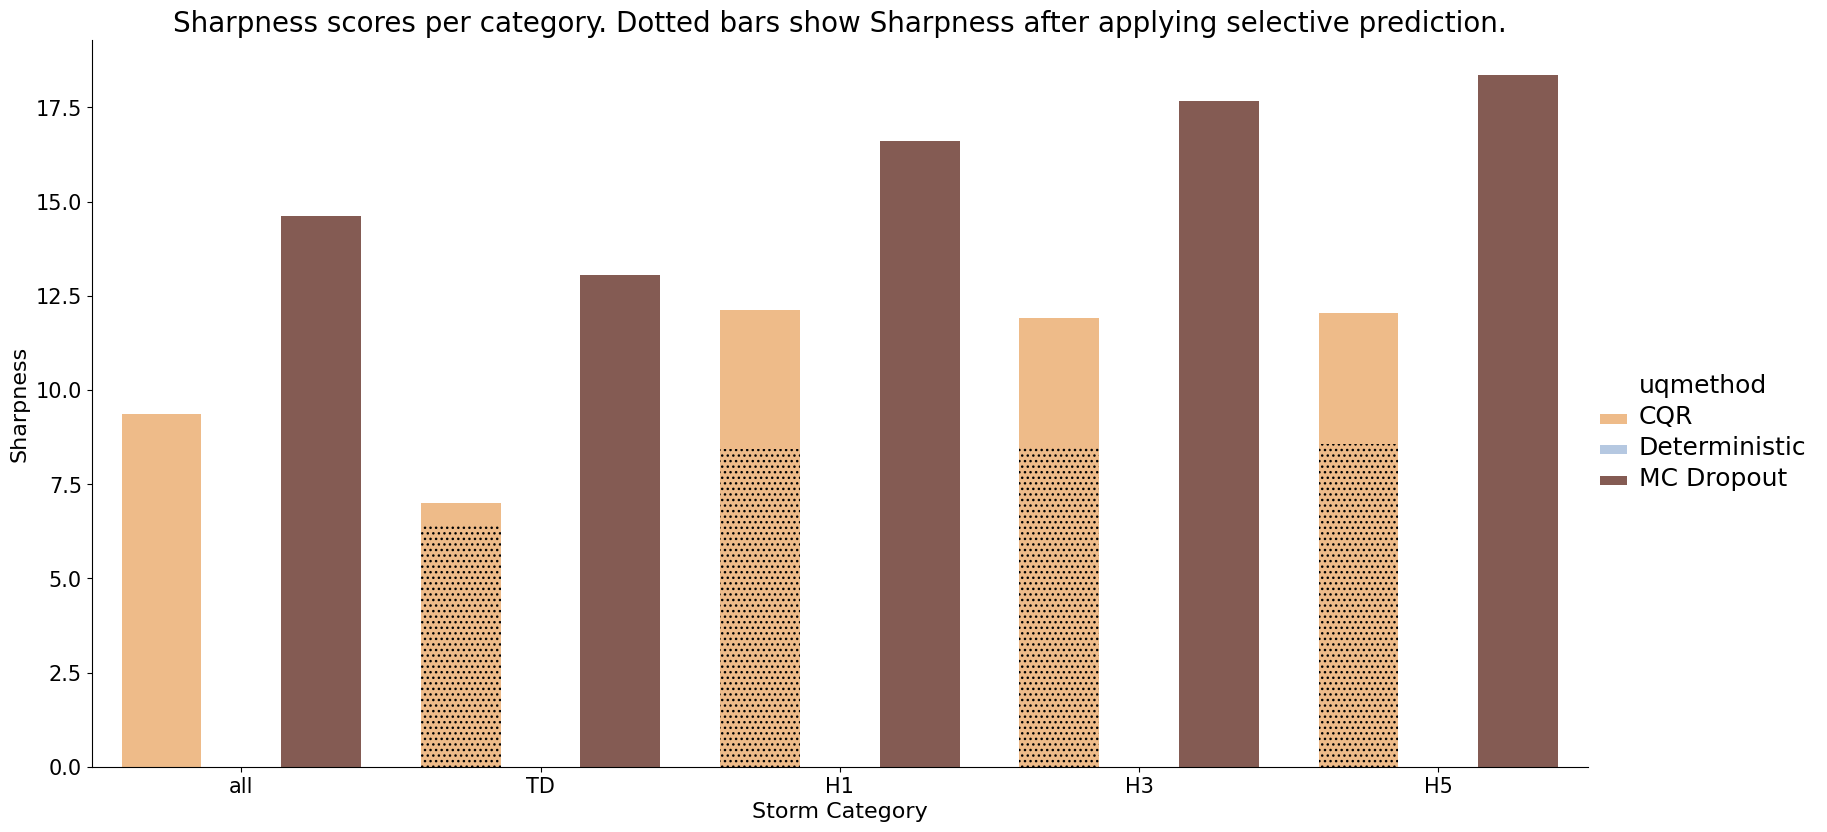

In [ ]:
def plot_sharpness(summary_table):
    summary_table["storm_category"] = summary_table["storm_category"].astype("category")
    hue_order = (
        summary_table[summary_table["uqmethod"] != "DERModel"]["uqmethod"]
        .unique()
        .tolist()
    )
    summary_table["storm_category"] = summary_table[
        "storm_category"
    ].cat.remove_unused_categories()
    summary_table = summary_table[
        summary_table["storm_category"].isin(STORM_DISPLAY_ORDER)
    ]

    g = sns.catplot(
        data=summary_table[summary_table["uqmethod"] != "DERModel"],
        kind="bar",
        x="storm_category",
        y="SHARP_All",
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax = g.ax

    sns.barplot(
        data=summary_table,
        x="storm_category",
        y="SHARP_Uncertainty_Less_Threshold",
        hue="uqmethod",
        alpha=0.0,
        ax=ax,
        hatch="...",
        hue_order=hue_order,
        order=STORM_DISPLAY_ORDER,
    )

    ax.get_legend().remove()

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.title(
        "Sharpness scores per category. Dotted bars show Sharpness after applying selective prediction.",
        fontsize=20,
    )
    plt.ylabel("Sharpness", fontsize=16)
    plt.xlabel("Storm Category", fontsize=16)
    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with the summary table as the argument
plot_sharpness(summary_table)

# Calibration

/tmp/ipykernel_19722/2340551546.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.catplot(


TypeError: 'NoneType' object is not iterable

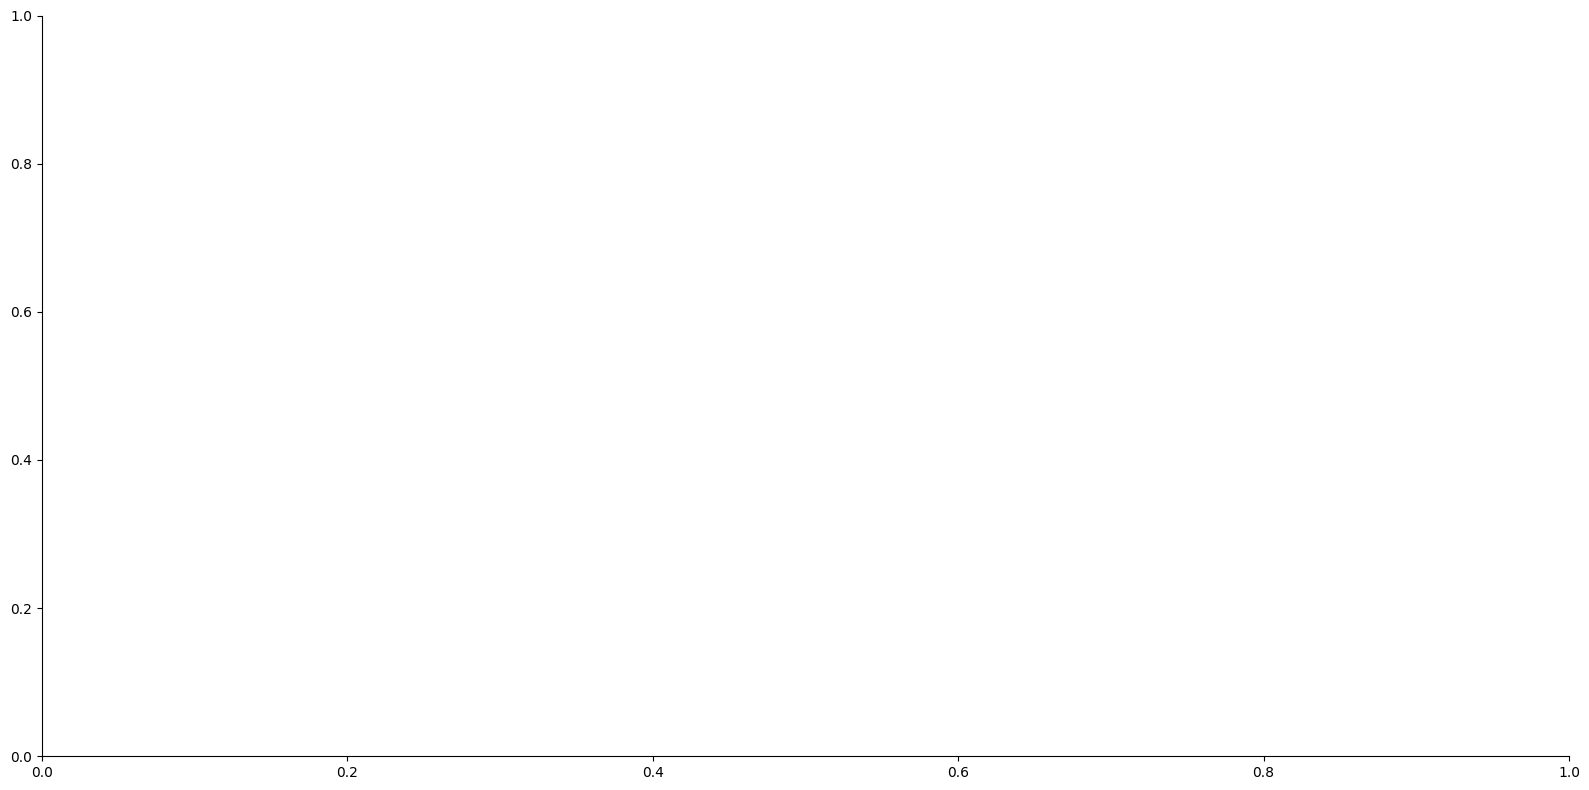

In [ ]:
def plot_boxplot(all_test_pred_df, split, metric):
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
    # remove categories with no predictions
    mask = plot_df.groupby("storm_category", observed=False)[metric].transform(
        lambda x: x.isna().any()
    )
    plot_df = plot_df[~mask]
    plot_df = plot_df[plot_df["storm_category"].isin(STORM_DISPLAY_ORDER)]
    plot_df["storm_category"] = plot_df["storm_category"].cat.remove_unused_categories()
    g = sns.catplot(
        plot_df,
        kind="box",
        x="storm_category",
        y=metric,
        hue="uqmethod",
        height=8,
        aspect=2,
        palette=color_palette,
    )

    ax = g.ax

    # Add horizontal lines behind each x value group
    for i, artist in enumerate(ax.artists):
        if i % 2 == 0:  # Check if it's an even index (i.e., group separator)
            artist.set_edgecolor("black")  # Set the edge color to black

    # Increase the size of the x and y ticks
    ax.tick_params(axis="both", which="major", labelsize=15)

    # Replace the uqmethod labels in the legend using the VAR_TO_PLOT_LABEL dictionary
    for t in g._legend.texts:
        t.set_text(
            VAR_TO_PLOT_LABEL[t.get_text()]
            if t.get_text() in VAR_TO_PLOT_LABEL
            else t.get_text()
        )

    plt.title(
        f"Boxplot of {VAR_TO_PLOT_LABEL[metric]} across category for {split} set.",
        fontsize=20,
    )
    plt.ylabel(f"{metric}", fontsize=20)
    plt.xlabel("Storm Category", fontsize=20)
    plt.setp(g._legend.get_texts(), fontsize="18")  # for legend text
    plt.setp(g._legend.get_title(), fontsize="18")  # for legend title
    g._legend.set_bbox_to_anchor((1.0, 0.5))


# Call the function with 'val' or 'train' as the split argument and 'mae' or any other metric as the metric argument
plot_boxplot(all_test_pred_df, DS_SPLIT, "mae")

In [ ]:
from typing import Union, List, Any
from matplotlib.axes import Axes
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists,
    get_proportion_lists_vectorized,
    adversarial_group_calibration,
    miscalibration_area,
    miscalibration_area_from_proportions,
)


def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list


# TODO Look up color pallete value
def plot_calibration(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    split_name: str,
    n_subset: Union[int, None] = None,
    curve_label: Union[str, None] = None,
    vectorized: bool = True,
    exp_props: Union[np.ndarray, None] = None,
    obs_props: Union[np.ndarray, None] = None,
    ax: Union[Axes, None] = None,
    prop_type: str = "interval",
) -> Axes:
    """Plot the observed proportion vs prediction proportion of outputs falling into a
    range of intervals, and display miscalibration area.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        n_subset: Number of points to plot after filtering.
        curve_label: legend label str for calibration curve.
        vectorized: plot using get_proportion_lists_vectorized.
        exp_props: plot using the given expected proportions.
        obs_props: plot using the given observed proportions.
        ax: matplotlib.axes.Axes object.
        prop_type: "interval" to measure observed proportions for centered prediction intervals,
                   and "quantile" for observed proportions below a predicted quantile.
                   Ignored if exp_props and obs_props are provided as inputs.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true] = filter_subset([y_pred, y_std, y_true], n_subset)

    if (exp_props is None) or (obs_props is None):
        # Compute exp_proportions and obs_proportions
        if vectorized:
            (exp_proportions, obs_proportions) = get_proportion_lists_vectorized(
                y_pred, y_std, y_true, prop_type=prop_type
            )
        else:
            (exp_proportions, obs_proportions) = get_proportion_lists(
                y_pred, y_std, y_true, prop_type=prop_type
            )
    else:
        # If expected and observed proportions are given
        exp_proportions = np.array(exp_props).flatten()
        obs_proportions = np.array(obs_props).flatten()
        if exp_proportions.shape != obs_proportions.shape:
            raise RuntimeError("exp_props and obs_props shape mismatch")

    # Set label
    if curve_label is None:
        curve_label = "Predictor"

    # Plot
    ax.plot([0, 1], [0, 1], "--", c="gray")
    ax.plot(
        exp_proportions,
        obs_proportions,
        label=curve_label.replace("Model", ""),
        c=color_palette[curve_label],
    )  # , c="#1f77b4")
    # ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.1)

    # Format plot
    ax.set_xlabel("Predicted Proportion in Interval", fontsize=16)
    ax.set_ylabel("Observed Proportion in Interval", fontsize=16)
    ax.axis("square")

    buff = 0.01
    ax.set_xlim([0 - buff, 1 + buff])
    ax.set_ylim([0 - buff, 1 + buff])

    ax.set_title(f"Avg Calibration {split_name}", fontsize=16)

    # Compute miscalibration area
    miscalibration_area = miscalibration_area_from_proportions(
        exp_proportions=exp_proportions, obs_proportions=obs_proportions
    )

    # Annotate plot with the miscalibration area
    # ax.text(
    #     x=0.95,
    #     y=0.05,
    #     s="Miscalibration area = %.2f" % miscalibration_area,
    #     verticalalignment="bottom",
    #     horizontalalignment="right",
    #     fontsize="small",
    # )

    return ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


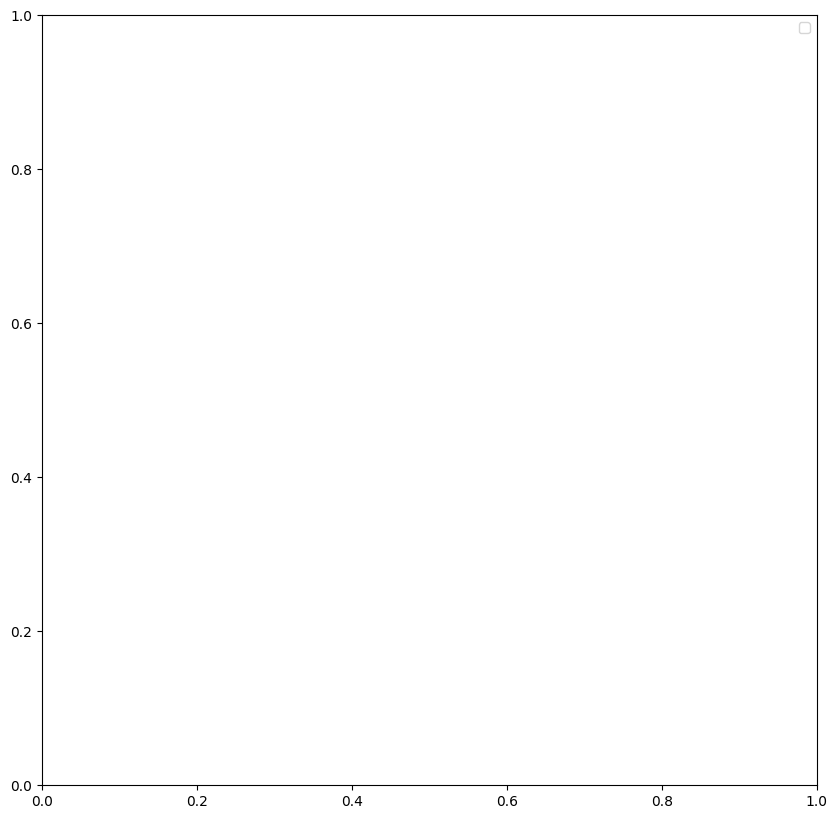

In [ ]:
uq_methods_to_show = [
    "MVERegression",
    "DeepEnsembleRegression",
    "DKLRegression",
    "LaplaceRegression",
    "ConformalQR",
    "QuantileRegression",
    "MCDropoutRegression",
    "SWAGRegression",
    "BNN_VI_ELBO_Regression",
    "DER",
]

split = "val"

fig, axs = plt.subplots(1, figsize=(10, 10))
for idx_uq, uq_method in enumerate(uq_methods_to_show):
    plot_df = uq_metric_df[uq_metric_df["uqmethod"] == uq_method].copy()
    plot_df = plot_df[plot_df["split"] == f"preds_{DS_SPLIT}"]
    plot_df.sort_values(by="split", inplace=True)
    plot_df.reset_index(inplace=True)
    # for idx, pred_path in enumerate(plot_df["pred_path"].unique()):
    for idx, row in plot_df.iterrows():
        split_df = pd.read_csv(row["pred_path"])
        if "pred_uct" in split_df.columns:
            plot_calibration(
                split_df["pred"].values.squeeze(),
                split_df["pred_uct"].values.squeeze(),
                split_df["target"].values.squeeze(),
                ax=axs,
                curve_label=uq_method,
                split_name=split,
            )
plt.legend()

# Correlation between Predictive Uncertainty and Errors

In [ ]:
def plot_correlation_heatmap(all_test_pred_df, split, corr_one, corr_two):
    filtered_df = all_test_pred_df[
        (all_test_pred_df["split"] == f"preds_{split}")
        & (all_test_pred_df["uqmethod"] != "DeterministicRegression")
    ]

    # Compute the correlation matrix
    corr_df = (
        filtered_df.groupby(["uqmethod", "storm_category"], observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Compute the aggregate correlation
    aggregate_corr_df = (
        filtered_df.groupby("uqmethod", observed=False)
        .apply(lambda group: group[[corr_one, corr_two]].corr())
        .reset_index()
    )

    # Add a 'storm_category' column to the aggregate correlation DataFrame
    aggregate_corr_df["storm_category"] = "all"

    # Append the aggregate correlation to the correlation DataFrame
    corr_df = pd.concat([corr_df, aggregate_corr_df], ignore_index=True)

    # Create a pivot table with 'uqmethod' and 'storm_category' as the index and columns, and the correlation between 'pred_uct' and 'mae' as the values
    pivot_table = corr_df.pivot_table(
        index="uqmethod", columns="storm_category", values="mae"
    )

    pivot_table = pivot_table.reindex(STORM_DISPLAY_ORDER, axis=1)

    # Create a heatmap from the pivot table
    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        vmin=0,
        vmax=1,
        annot_kws={"fontsize": 12},
    )

    # Set the title and increase the size of the labels
    plt.title(
        f"Correlation between {VAR_TO_PLOT_LABEL[corr_one]} and {VAR_TO_PLOT_LABEL[corr_two]}",
        fontsize=20,
    )
    plt.xlabel("Storm Category", fontsize=15)
    plt.ylabel("UQ Method", fontsize=15)

    # Increase the size of the tick labels
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    # Replace the y-tick labels using the VAR_TO_PLOT_LABEL dictionary
    yticklabels = [
        VAR_TO_PLOT_LABEL[label.get_text()]
        if label.get_text() in VAR_TO_PLOT_LABEL
        else label.get_text()
        for label in plt.gca().get_yticklabels()
    ]
    plt.gca().set_yticklabels(yticklabels)

    # Show the plot
    plt.show()


# Call the function with the all_test_pred_df DataFrame, 'val' as the split argument, and 'mae' and 'pred_uct' as the correlation arguments
plot_correlation_heatmap(all_test_pred_df, DS_SPLIT, "mae", "pred_uct")

ValueError: cannot insert storm_category, already exists

# Track Prediction Visualization

In [ ]:
# get a config from the overview_df
config = OmegaConf.load(os.path.join(os.path.dirname(dir_paths[0]), "config.yaml"))
datamodule = instantiate(config.datamodule)
datamodule.setup(stage="fit")
datamodule.setup(stage="test")

DF LENTGTH
LENGTH train 70257
DF LENTGTH
LENGTH train 70257
DF LENTGTH
LENGTH test 44377


In [ ]:
dataset = datamodule.dataset
train_ds = datamodule.train_dataset
val_ds = datamodule.val_dataset
test_ds = datamodule.test_dataset
calib_ds = datamodule.calibration_dataset

print(len(dataset)), print(len(train_ds)), print(len(val_ds)), print(
    len(calib_ds)
), print(len(test_ds))

69269
56348
10336
2585
43635


(None, None, None, None, None)

In [ ]:
split_df = all_test_pred_df[
    all_test_pred_df["split"] == f"preds_{str('test')}"
].reset_index()
grouped = split_df.groupby(["uqmethod", "split"])

# Get the size of each group
group_sizes = grouped.size()

# Print the sizes
print(group_sizes)

uqmethod                 split     
BNN_VI_ELBO_Regression   preds_test    43635
DeterministicRegression  preds_test    43635
QuantileRegression       preds_test    43635
SWAGRegression           preds_test     8448
dtype: int64


In [ ]:
dataset.sequence_df

,storm_id,subsequences,wind_speed,class_label
0,abs,"[0, 1, 2]",45,1
1,abs,"[1, 2, 3]",52,1
2,abs,"[2, 3, 4]",53,1
3,abs,"[3, 4, 5]",62,1
4,abs,"[4, 5, 6]",63,1
...,...,...,...,...
69264,zzp,"[219, 220, 221]",42,1
69265,zzp,"[220, 221, 222]",40,1
69266,zzp,"[221, 222, 223]",37,1
69267,zzp,"[222, 223, 224]",35,1


In [ ]:
test_ds.sequence_df

,storm_id,subsequences,wind_speed,class_label
0,acd,"[123, 124, 125]",33,0
1,acd,"[124, 125, 126]",33,0
2,acd,"[125, 126, 127]",32,0
3,acd,"[126, 127, 128]",32,0
4,acd,"[127, 128, 129]",31,0
...,...,...,...,...
43630,zza,"[172, 173, 174]",20,0
43631,zza,"[173, 174, 175]",20,0
43632,zza,"[174, 175, 176]",20,0
43633,zza,"[175, 176, 177]",20,0


In [ ]:
test_ds.sequence_df[test_ds.sequence_df["storm_id"] == "zoi"]

,storm_id,subsequences,wind_speed,class_label


In [ ]:
unique_storm_ids = test_ds.sequence_df["storm_id"].unique()
set(unique_storm_ids)

{'acd',
 'aek',
 'agb',
 'agl',
 'agp',
 'aig',
 'aiz',
 'akq',
 'alc',
 'ano',
 'aox',
 'ati',
 'awy',
 'aya',
 'azb',
 'bav',
 'bdi',
 'bdr',
 'bef',
 'bib',
 'bic',
 'ble',
 'blt',
 'blz',
 'bmj',
 'bmm',
 'bpu',
 'btz',
 'buc',
 'caa',
 'cdq',
 'cfk',
 'cjx',
 'cjz',
 'cmg',
 'cqv',
 'crw',
 'cva',
 'cwf',
 'cxh',
 'cym',
 'daa',
 'dfh',
 'dft',
 'dgc',
 'dhv',
 'djm',
 'dky',
 'don',
 'dpf',
 'dqn',
 'dsc',
 'dtj',
 'dva',
 'dvp',
 'dwc',
 'dwp',
 'dzw',
 'eef',
 'eem',
 'eke',
 'eko',
 'emz',
 'eoi',
 'erd',
 'erp',
 'etd',
 'eve',
 'eze',
 'fak',
 'fay',
 'fch',
 'ffk',
 'fgj',
 'fgs',
 'fhl',
 'fit',
 'fkd',
 'fla',
 'fmv',
 'fna',
 'fnu',
 'foj',
 'fpr',
 'frh',
 'frt',
 'frv',
 'ftp',
 'fvj',
 'fwn',
 'fyt',
 'fzl',
 'fzw',
 'gfk',
 'gfw',
 'ggy',
 'gil',
 'gio',
 'gix',
 'gku',
 'gmf',
 'gqc',
 'gux',
 'gvy',
 'gxi',
 'hcg',
 'hdi',
 'hep',
 'hfh',
 'hgj',
 'hgl',
 'hhi',
 'hht',
 'hkz',
 'hld',
 'hlj',
 'hlv',
 'hnb',
 'hoh',
 'hpo',
 'hqu',
 'htd',
 'hvz',
 'hww',
 'hze',


In [ ]:
split_df = all_test_pred_df[
    all_test_pred_df["split"] == f"preds_{str('train')}"
].reset_index()
grouped = split_df.groupby(["uqmethod", "split"])

# Get the sets of storm_id, relative_time, and index for each group
storm_id_sets = grouped["storm_id"].apply(lambda x: sorted(list(set(x))))
relative_time_sets = grouped["relative_time"].apply(lambda x: sorted(list(set(x))))
index_sets = grouped["index"].apply(lambda x: sorted(list(set(x))))

print(storm_id_sets)

for storm_id in storm_id_sets:
    print(storm_id)

# Check if all storm_id, relative_time, and index sets are the same
is_same_storm_id_set = all(
    storm_id_set == set(unique_storm_ids) for storm_id_set in storm_id_sets
)
is_same_relative_time_set = all(
    relative_time_set == relative_time_sets.iloc[0]
    for relative_time_set in relative_time_sets
)
is_same_index_set = all(index_set == index_sets.iloc[0] for index_set in index_sets)

# Print the results
print("Same set of storm_id for each uq_method and split:", is_same_storm_id_set)
print(
    "Same set of relative_time for each uq_method and split:", is_same_relative_time_set
)
print("Same set of index for each uq_method and split:", is_same_index_set)

KeyError: 'Column not found: storm_id'

In [ ]:
# Get the size of each group
group_sizes = grouped.size()

# Print the sizes
print(group_sizes)

uqmethod                 split      
BNN_VI_ELBO_Regression   preds_train     56704
ConformalQR              preds_train    112923
DeepEnsembleRegression   preds_train     56797
DeterministicRegression  preds_train    111377
QuantileRegression       preds_train    111377
SWAGRegression           preds_train     56704
dtype: int64


,storm_id,error,n_samples
10,djr,2.718134,98
11,pot,2.722346,159
12,wic,2.747044,154
13,mca,2.749209,80
14,yit,2.839500,77
15,dsr,2.845330,70
16,phw,2.854779,172
17,vlo,2.860228,278
18,hoo,2.902306,155
19,yab,2.904082,228


             pred   pred_uct  lower_quant  upper_quant  aleatoric_uct  \
43635   47.392983   8.559907          NaN          NaN            NaN   
43636   52.454563   8.405151          NaN          NaN            NaN   
43637   55.216659   8.786808          NaN          NaN            NaN   
43638   56.590249  10.336061          NaN          NaN            NaN   
43639   57.569650  10.344306          NaN          NaN            NaN   
...           ...        ...          ...          ...            ...   
395748  88.275780  13.201594          NaN          NaN       0.636052   
395749  90.837944  13.081619          NaN          NaN       0.629979   
395750  89.681460  12.515790          NaN          NaN       0.601774   
395751  91.981313  12.383934          NaN          NaN       0.595945   
395752  93.671287  13.082333          NaN          NaN       0.629906   

           target storm_id  relative_time  ocean  index  ...        split  \
43635   45.000000      abs           5400     

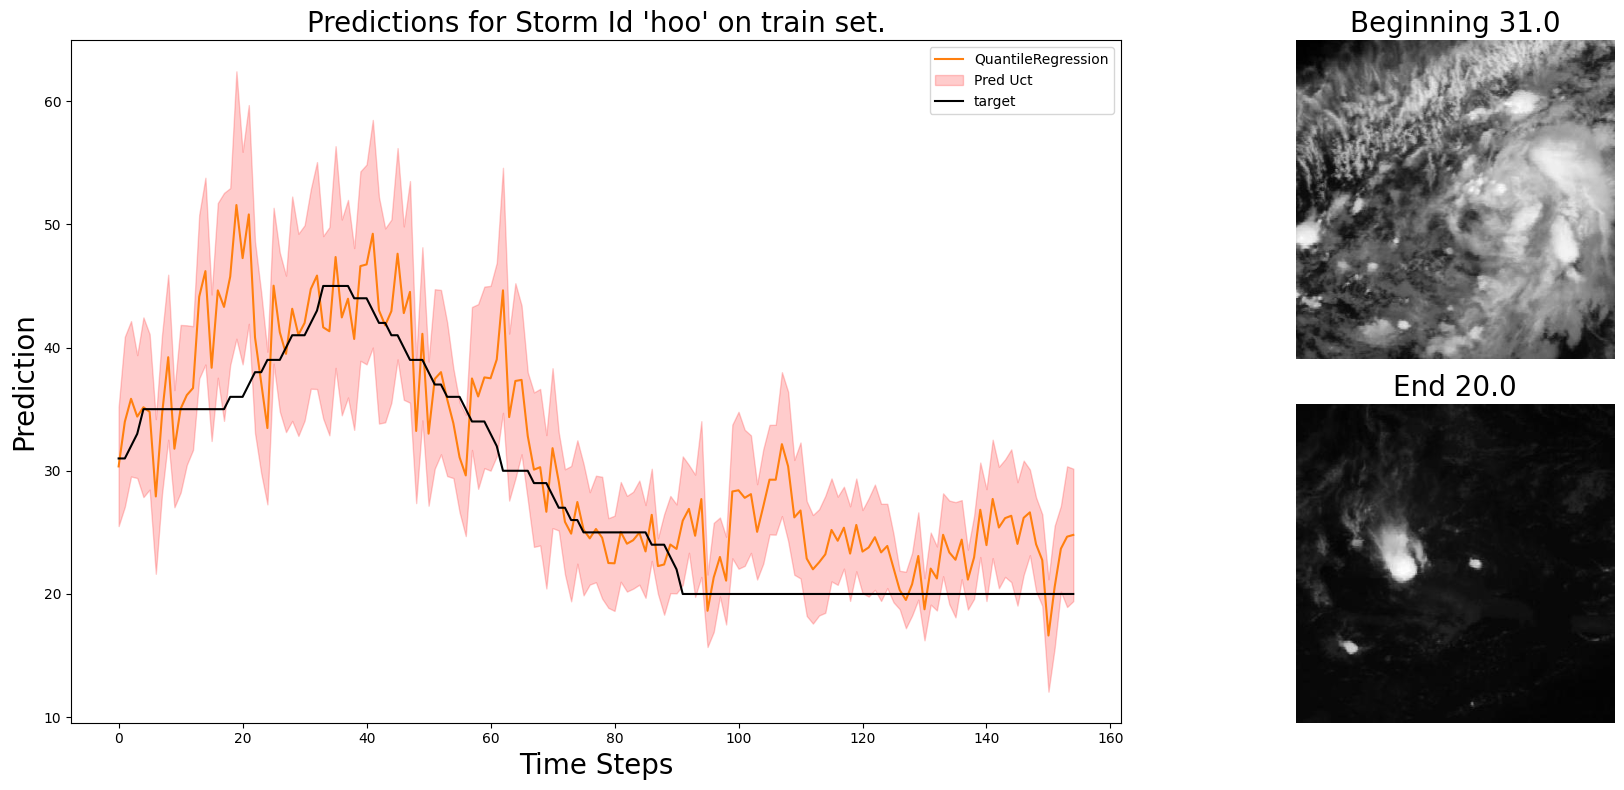

In [ ]:
DS_SPLIT = "train"

# compute average error per track, and add a column that denotes the number of samples per storm_id
error_by_storm_id = (
    all_test_pred_df[all_test_pred_df["split"] == f"preds_{DS_SPLIT}"]
    .groupby(["storm_id"], observed=False)
    .apply(lambda x: np.mean(np.abs(x["pred"].values - x["target"].values)))
    .reset_index()
)
error_by_storm_id.columns = ["storm_id", "error"]
unique_samples_df = all_test_pred_df[
    all_test_pred_df["split"] == f"preds_{DS_SPLIT}"
].drop_duplicates(subset=["storm_id", "relative_time"])

error_by_storm_id["n_samples"] = (
    unique_samples_df.groupby(["storm_id"], observed=False)
    .apply(lambda x: len(x))
    .values
)

# order the tracks
error_by_storm_id.sort_values(by="error", inplace=True)

# now select the top and bottom 5 given that there are between 50 and 100 samples
error_by_storm_id = error_by_storm_id[error_by_storm_id["n_samples"] > 50].reset_index(
    drop=True
)
display(error_by_storm_id.iloc[10:20,:])
# error_by_storm_id = error_by_storm_id[error_by_storm_id["n_samples"]<100]

bottom_id = error_by_storm_id.iloc[-1]["storm_id"]
top_id = error_by_storm_id.iloc[0]["storm_id"]


def plot_track(
    all_test_pred_df,
    storm_id,
    split,
):
    """Generate a plot showing the predictions for a given storm_id over time."""
    plot_df = all_test_pred_df[all_test_pred_df["split"] == f"preds_{split}"]
    print(plot_df)
    print(plot_df["uqmethod"].unique())
    plot_df = plot_df[plot_df["storm_id"] == storm_id]
    print(plot_df["uqmethod"].unique())
    plot_df = plot_df.sort_values(by="relative_time")

    # a mapping from relative_time to timestep
    unique_times = plot_df["relative_time"].unique()
    time_to_timestep = {time: i for i, time in enumerate(unique_times)}
    plot_df["timestep"] = plot_df["relative_time"].map(time_to_timestep)

    # iterate over the uqmethods
    unique_methods = plot_df["uqmethod"].unique()

    unique_methods = ["QuantileRegression"]

    print(unique_methods)

    ds = {"train": dataset, "val": dataset, "test": test_ds}[split]

    # Create a figure and a grid of subplots
    fig = plt.figure(figsize=(20, 8))
    gs = GridSpec(2, 2, figure=fig)

    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    for idx, method in enumerate(unique_methods):
        print(method)
        method_df = plot_df[plot_df["uqmethod"] == method]
        ax1.plot(
            method_df["timestep"],
            method_df["pred"],
            label=method,
            c=color_palette[method],
        )
        ax1.fill_between(
            method_df["timestep"],
            method_df["pred"] - method_df["pred_uct"],
            method_df["pred"] + method_df["pred_uct"],
            color="red",
            alpha=0.2,
            label="Pred Uct",
        )
        # # print(method_df.iloc[0]["pred_path"])
        # ax1.fill_between(
        #     method_df["timestep"],
        #     method_df["pred"] - SELECTIVE_THRESH,
        #     method_df["pred"] + SELECTIVE_THRESH,
        #     color="blue",
        #     alpha=0.2,
        #     label="Selective Prediction Range",
        # )

    # plot ground truth just from last one since it is the same for all
    ax1.plot(method_df["timestep"], method_df["target"], label="target", c="black")

    ax1.legend()

    ax1.set_title(f"Predictions for Storm Id '{storm_id}' on {split} set.", fontsize=20)
    ax1.set_ylabel("Prediction", fontsize=20)
    ax1.set_xlabel("Time Steps", fontsize=20)

    # Display the image from the beginning timestep
    first_image_index = method_df.iloc[0]["index"]
    
    first_sample = ds[first_image_index]
    first_image = first_sample["input"].permute(1, 2, 0).numpy()[..., 0] / 255
    ax2.imshow(first_image, cmap="gray")
    ax2.set_title(f"Beginning {first_sample['target'].item()}", fontsize=20)
    ax2.axis("off")

    # Display the image from the end timestep
    last_image_index = method_df.iloc[-1]["index"]
    last_sample = ds[last_image_index]
    last_image = last_sample["input"].permute(1, 2, 0).numpy()[..., 0] / 255
    ax3.imshow(last_image, cmap="gray")
    ax3.set_title(f"End {last_sample['target'].item()}", fontsize=20)
    ax3.axis("off")

    plt.tight_layout()
    plt.show()


plot_track(all_test_pred_df, "hoo", DS_SPLIT)


# COMBOS To keep track of
# "bcf", "train"
# "ota", "train"

# Data Exploration

In [ ]:
from tropical_cyclone_ds import TropicalCycloneSequence

path = "/p/project/hai_uqmethodbox/data/tropical_cyclone"

train_ds = TropicalCycloneSequence(root=path)

Num samples: 69269


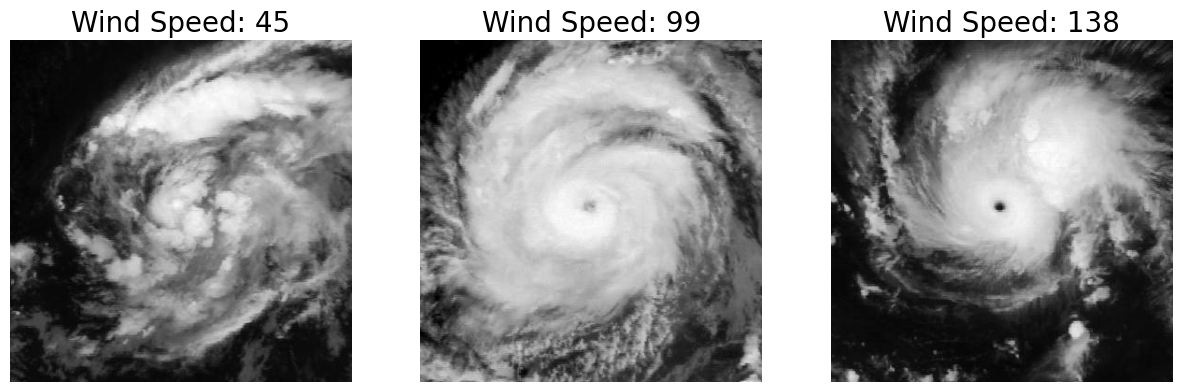

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


ranges = [CLASS_BINS["TS"], CLASS_BINS["H3"], CLASS_BINS["H5"]]

# Create a subplot to display the images
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# for i, (min_speed, max_speed) in enumerate(ranges):
#     # Iterate through the dataset until you find a sample in the current wind speed range
#     for idx, sample in tqdm(enumerate(train_ds)):

#         if min_speed <= int(sample["target"]) < max_speed:
#             print(idx)
#             break

#     image = sample["input"].numpy().transpose(1, 2, 0) / 255

#     # Display the image and set the title to the target value
#     axes[i].imshow(image, cmap='gray')
#     axes[i].set_title(f'Wind Speed: {int(sample["target"])}')
#     axes[i].axis('off')

# plt.show()

# Define the indices of the samples you need
indices = [0, 2646, 2555]

# Create a subplot to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, index in enumerate(indices):
    # Retrieve the sample from the dataset
    sample = train_ds[index]

    image = sample["input"].numpy().transpose(1, 2, 0)[..., 0] / 255

    # Display the image and set the title to the target value
    axes[i].imshow(image, cmap="gray")
    axes[i].set_title(f'Wind Speed: {int(sample["target"])}', fontsize=20)
    axes[i].axis("off")

plt.show()

In [ ]:
def retrieve_item(item, ds):
    source_id = item["href"].split("/")[0]
    if "train_source" in source_id:
        split = "train"
    else:
        split = "test"

    directory = os.path.join(
        ds.root,
        "_".join([train_ds.collection_id, split, "{0}"]),
        source_id.replace("source", "{0}"),
    )
    features = ds._load_features(directory)
    data = {"path": source_id, **features}
    # don't nee the tensor label, already includes 'wind_speed'
    data.pop("label")
    # but add original split where it is coming from
    data["split"] = split
    return data


def retrieve_collection_df(ds):
    def parallel_process(items, ds, num_processes: int):
        # Create a multiprocessing pool with the specified number of processes
        pool = Pool(processes=num_processes)
        # Map the paths to the process_path function and execute in parallel
        read_items = pool.starmap(retrieve_item, [(item, ds) for item in items])
        # Close the pool of processes
        pool.close()
        # Combine the resulting DataFrames into a single DataFrame
        df = pd.DataFrame.from_dict(read_items)
        return df

    # Specify the number of processes to use for parallel execution
    num_processes = 8  # Adjust according to your system capabilities
    items = [item for item in ds.collection]
    # Call the parallel_process function to execute the processing in parallel
    df = parallel_process(items, ds, num_processes)

    return df

In [ ]:
train_df = retrieve_collection_df(train_ds)
train_df["wind_speed"] = train_df["wind_speed"].astype(int)

In [ ]:
train_df["storm_category"] = pd.cut(
    train_df["wind_speed"], bins=BIN_EDGES, labels=CLASS_LABELS, right=False
)
train_df

,path,storm_id,relative_time,ocean,wind_speed,split,storm_category
0,nasa_tropical_storm_competition_train_source_n...,nhe,0,2,34,train,TS
1,nasa_tropical_storm_competition_train_source_n...,nhe,1800,2,34,train,TS
2,nasa_tropical_storm_competition_train_source_n...,nhe,3600,2,34,train,TS
3,nasa_tropical_storm_competition_train_source_n...,nhe,5402,2,33,train,TS
4,nasa_tropical_storm_competition_train_source_n...,nhe,9001,2,32,train,TD
...,...,...,...,...,...,...,...
70252,nasa_tropical_storm_competition_train_source_y...,yti,255601,1,45,train,TS
70253,nasa_tropical_storm_competition_train_source_y...,yti,259201,1,45,train,TS
70254,nasa_tropical_storm_competition_train_source_y...,yti,262801,1,45,train,TS
70255,nasa_tropical_storm_competition_train_source_y...,yti,266401,1,45,train,TS


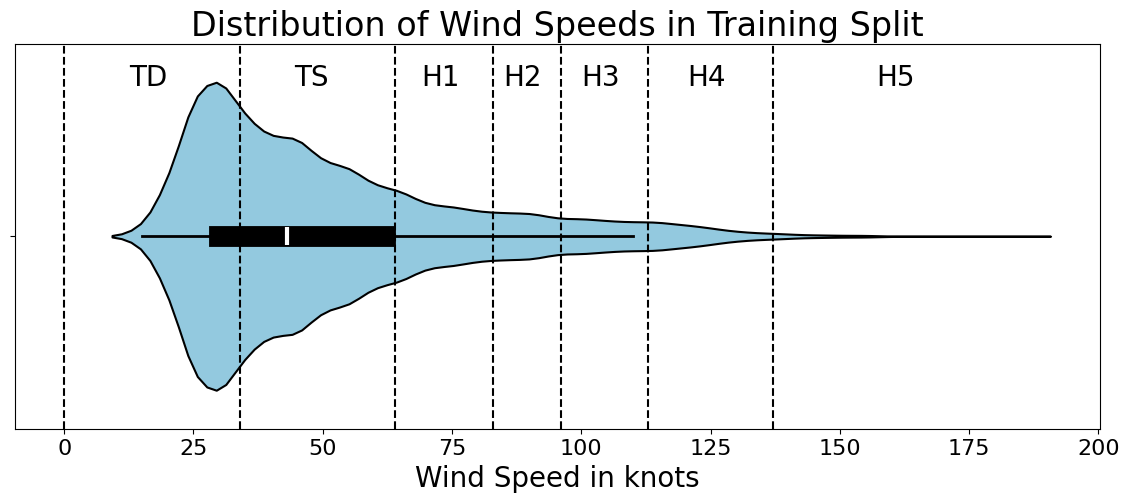

In [ ]:
import seaborn as sns


CLASS_BINS = {
    "TD": (0, 33),
    "TS": (34, 63),
    "H1": (64, 82),
    "H2": (83, 95),
    "H3": (96, 112),
    "H4": (113, 136),
    "H5": (137, np.inf),
}

CLASS_BINS["H5"] = (137, train_df["wind_speed"].max())

# Create a horizontal violin plot of the wind_speed variable
sns.violinplot(
    x=train_df["wind_speed"],
    orient="h",
    color="skyblue",
    inner_kws=dict(box_width=15, whis_width=2, color="black"),
    linewidth=1.5,
    linecolor="k",
)

# Add vertical lines to represent the boundaries of the storm categories
# Add vertical lines to represent the boundaries of the storm categories
for category, (min_speed, max_speed) in CLASS_BINS.items():
    midpoint = (min_speed + max_speed) / 2 - 4
    plt.axvline(x=min_speed, color="black", linestyle="--")
    plt.text(
        midpoint,
        plt.gca().get_ylim()[1] * 0.9,
        category,
        color="black",
        fontsize=20,
        verticalalignment="top",
    )

# Add labels and title with larger font size
plt.xlabel("Wind Speed in knots", fontsize=20)
plt.title("Distribution of Wind Speeds in Training Split", fontsize=24)

# Increase the size of the x-ticks
plt.xticks(fontsize=16)

# Show the plot
plt.show()

In [ ]:
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df["wind_speed"] = full_df["wind_speed"].astype(int)

full_df["storm_category"] = pd.cut(
    full_df["wind_speed"], bins=bins, labels=labels, right=False
)
full_df

NameError: name 'test_df' is not defined

## Wind Speed across splits

In [ ]:
fig, axs = plt.subplots(1)
sns.violinplot(full_df, x="split", y="wind_speed", ax=axs)
axs.set_title("Wind Speed for train and test split.")

## Wind Speed across categories

In [ ]:
# fig, axs = plt.subplots(1)
sns.catplot(full_df, kind="box", x="storm_category", y="wind_speed", hue="split")
plt.title("Boxplot of wind speeds across category and split")

In [ ]:
fig, axs = plt.subplots(1)
sns.countplot(full_df, x="storm_category", hue="split", ax=axs)
plt.title("Count samples per storm category")

In [ ]:
train_df["wind_speed"].astype(int).values

In [ ]:
np.save(
    "/p/project/hai_uqmethodbox/nils/lightning-uq-box/experiments/image-regression/configs/tropical_cyclone/target.npy",
    (train_df["wind_speed"].astype(float).values - TARGET_MEAN) / TARGET_STD,
)